In [1]:
import re
import collections
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
import os
import random
from joint_stemmer_postagger import TurkishStemmerPOSTagger
from nltk.tokenize.casual import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
from IPython.display import Markdown, display
import _pickle as pickle
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from sklearn.manifold import TSNE
from networkx.algorithms import community
import pandas as pd
from IPython.display import HTML, display

In [2]:
def printmd(string):
    """
    Print markdown strings
    """
    display(Markdown(string))

def asciify_txt(txt):
    """
    Convert non-ascii Turkish characters (ı, ş , ğ) to their ascii forms (i, s, g)
    :param txt: String variable tobe asciified
    :return: Asciified string
    """
    asciified = txt
    asciified = asciified.replace("ı", "i")
    asciified = asciified.replace("ü", "u")
    asciified = asciified.replace("ş", "s")
    asciified = asciified.replace("ö", "o")
    asciified = asciified.replace("ğ", "g")
    asciified = asciified.replace("ç", "c")
    asciified = asciified.replace("İ", "I")
    asciified = asciified.replace("Ü", "U")
    asciified = asciified.replace("Ş", "S")
    asciified = asciified.replace("Ö", "O")
    asciified = asciified.replace("Ğ", "G")
    asciified = asciified.replace("Ç", "C")
    return asciified

In [3]:
# READ TURKISH STOP WORDS FROM FILE
stop_words = []
with open("resources/nlp/turkish/stopwords.txt", "r", encoding="UTF-8") as f:
    for line in f:
        stop_words.append(line.strip())
ascified_stop_words = []
for stop_word in stop_words:
    ascified_stop_words.append(asciify_txt(stop_word))

In [4]:
# READ SEMEVAL RESTAURANT DATASET
# Preprocessing steps: 
# (1) Tokenization, 
# (2) Lowercase all characters
# (3) Stop word removal
# (4) Non-word removal (punctuations and numbers)
# (5) Naive rule based stemming for Turkish 
# (6) Asciificaiton

# FILE PATHS
raw_data_path = "resources/data/restaurant_sentence_level.txt"
preprocesed_data_path = "resources/data/restaurant_sentence_level_preprocessed.txt"

# Create tokenizer and stemmer objects
tokenizer = TweetTokenizer()
stemmer = TurkishStemmerPOSTagger.create_from_existed_model()

raw_reviews = []
preprocessed_reviews = []
first_level_labels = []
second_level_labels = []

# IF PREPROCESSED FILE IS CREATED BEFORE, USE IT TO READ DATASET
if os.path.isfile(preprocesed_data_path):
    with open(preprocesed_data_path, "r", encoding="UTF-8") as f:
        for line in f:
            splits = line.strip().split("\t")
            if len(splits) != 3:
                print("Error in line: {}".format(line))
            review = splits[0]
            raw_reviews.append(review)
            preprocessed_review = splits[1]
            preprocessed_reviews.append(preprocessed_review)
            labels = list(set(splits[2].split(" ")))
            first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
            second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
# OTHERWISE APPLY PREPROCESSING STEPS TO RAW DATA THEN SAVE IT FOR FURTHER USE
else:
    with open(preprocesed_data_path, "w", encoding="UTF-8") as w:
        with open(raw_data_path, "r", encoding="UTF-8") as f:
            for line in f:
                splits = line.strip().split("\t")
                # Check if review has a label
                if len(splits) == 2:
                    review = splits[0].strip()
                    review = re.sub("[\t\r\n ]+", " ", review)
                    raw_reviews.append(review)
                    review = review.lower()
                    tokens = tokenizer.tokenize(review)
                    tokens = [token for token in tokens if re.match(r"^[a-zA-ZİĞŞÜÇÖığüöçş]+$", token) and token not in stop_words]
                    stems = stemmer.get_stems(tokens)
                    stems = [asciify_txt(stem) for stem in stems if asciify_txt(stem) not in ascified_stop_words]
                    preprocessed_review = " ".join(stems)
                    preprocessed_reviews.append(preprocessed_review)
                    labels = list(set(splits[1].split(" ")))
                    first_level_labels.append([re.sub(r"#.*$", "", s) for s in labels])
                    second_level_labels.append([re.sub(r"^.*#", "", s) for s in labels])
                    w.write("{}\t{}\t{}\n".format(review, preprocessed_review, " ".join(labels)))


** Number of reviews: ** 1228

** FIRST LEVEL LABELS: ** 
 - AMBIENCE
 - RESTAURANT
 - LOCATION
 - SERVICE
 - FOOD
 - DRINKS  
 - ** Number of first level labels: ** 6

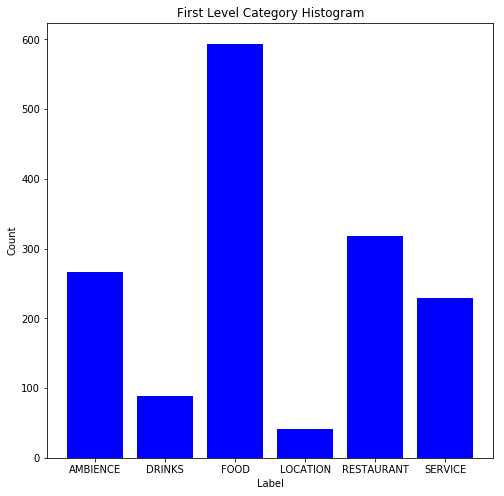

** SECOND LEVEL LABELS: ** 
 - RESTAURANT
MISCELLANEOUS
 - DRINKS
QUALITY
 - FOOD
STYLE_OPTIONS
 - DRINKS
PRICES
 - LOCATION
GENERAL
 - FOOD
QUALITY
 - RESTAURANT
PRICES
 - DRINKS
STYLE_OPTIONS
 - FOOD
PRICES
 - SERVICE
GENERAL
 - AMBIENCE
GENERAL
 - RESTAURANT
GENERAL  
 - ** Number of second level labels: ** 12

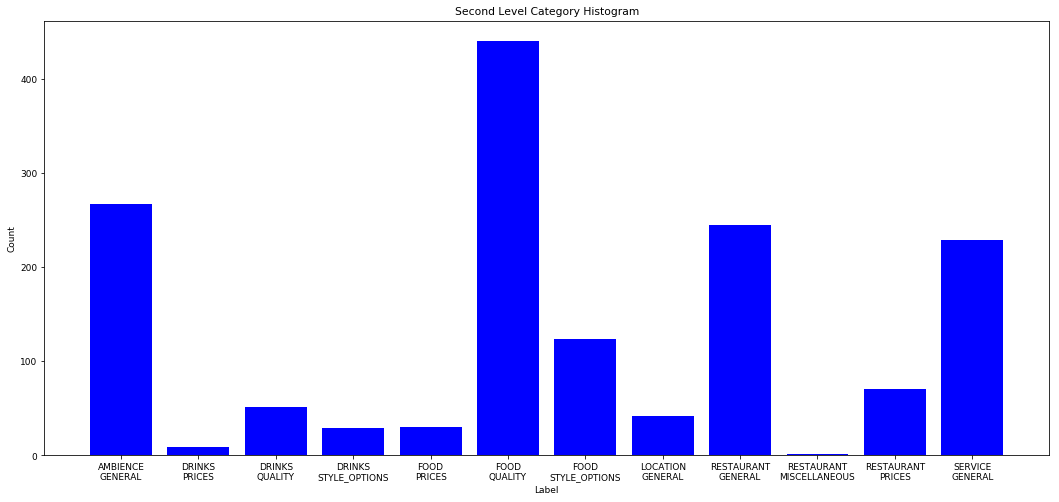

In [5]:
# VISUALIZE DATA STATISTICS
printmd("** Number of reviews: ** {}".format(len(first_level_labels)))

# FIRST LEVEL LABELS
matplotlib.rcParams.update({'font.size': 10})
first_level_label_counts = {}
for cur_labels in first_level_labels:
        for label in cur_labels:
            if label not in first_level_label_counts:
                first_level_label_counts[label] = 1
            else:
                first_level_label_counts[label] += 1
fig, ax = plt.subplots(figsize=(8, 8))
first_level_labels_set = [label for label, _ in first_level_label_counts.items()]
first_level_counts_set = [count for _, count in first_level_label_counts.items()]

# PRINT FIRST LEVEL LABELS STATS
printmd("** FIRST LEVEL LABELS: ** \n - {}  \n - ** Number of first level labels: ** {}"
        .format("\n - ".join(first_level_labels_set), len(first_level_labels_set)))



# PLOT FIRST LEVEL LABELS HISTOGRAM
plt.bar(first_level_labels_set, first_level_counts_set, width=0.80, color='b')
plt.title("First Level Category Histogram")
plt.ylabel("Count")
plt.xlabel("Label")
ax.set_xticks([l for l in first_level_labels_set])
ax.set_xticklabels(first_level_labels_set)
plt.show()

# SECOND LEVEL LABELS
matplotlib.rcParams.update({'font.size': 9})
second_level_label_counts = {}
for cur_labels1, cur_labels2 in zip(first_level_labels, second_level_labels):
        for label1, label2 in zip(cur_labels1, cur_labels2):
            label = label1 + "\n" + label2
            if label not in second_level_label_counts:
                second_level_label_counts[label] = 1
            else:
                second_level_label_counts[label] += 1
second_level_labels_set = [label for label, _ in second_level_label_counts.items()]
second_level_counts_set = [count for _, count in second_level_label_counts.items()]
                

# PRINT FIRST LEVEL LABELS STATS
printmd("** SECOND LEVEL LABELS: ** \n - {}  \n - ** Number of second level labels: ** {}"
        .format("\n - ".join(second_level_labels_set), len(second_level_labels_set)))


# PLOT SECOND LEVEL LABELS HISTOGRAM
fig, ax = plt.subplots(figsize=(18, 8))
plt.bar(second_level_labels_set, second_level_counts_set, width=0.80, color='b')

plt.title("Second Level Category Histogram")
plt.ylabel("Count")
plt.xlabel("Label")
ax.set_xticks([l for l in second_level_labels_set])
ax.set_xticklabels(second_level_labels_set)
plt.show()

In [6]:
# ALL LISTS BELOW SHOULD BE IN EQUAL LENGTH
assert len(raw_reviews) == len(preprocessed_reviews) == len(first_level_labels) == len(second_level_labels)

In [7]:
# PRINT AN EXAMPLE REVIEW
example_review_index = 105

printmd("**Raw review:** {}".format(raw_reviews[example_review_index]))
printmd("**Preprocessed review:** {}".format(preprocessed_reviews[example_review_index]))
printmd("**First level labels:**\n -  {}".format("\n - ".join(label for label in first_level_labels[example_review_index])))
printmd("**Second level labels:**\n - {}".format("\n - ".join(label1 + "/" + label2 for label1, label2
                                                              in zip(first_level_labels[example_review_index],
                                                                     second_level_labels[example_review_index]))))

**Raw review:** fiyatlar normal, servis cok yavaş, tuvaletler ise pis.

**Preprocessed review:** fiyat normal servis yavas tuvalet pis

**First level labels:**
 -  AMBIENCE
 - SERVICE
 - RESTAURANT

**Second level labels:**
 - AMBIENCE/GENERAL
 - SERVICE/GENERAL
 - RESTAURANT/PRICES

In [8]:
# CONSTRUCT TF-IDF SIMILARITY MATRIX
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(preprocessed_reviews)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_counts)
X_train_tf = tf_transformer.transform(X_train_counts)
printmd("** TF-IDF REVIEW-TERM MATRIX **")
printmd("** Number of reviews: ** {}".format(X_train_tf.shape[0]))
printmd("** Number of terms: ** {}".format(X_train_tf.shape[1]))
printmd("** Shape of TF-IDF matrix: ** {}".format(X_train_tf.shape))
print()

tfidf_adjacency_matrix = 1 - pairwise_distances(X_train_tf, metric="cosine")
printmd("** TF-IDF ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(tfidf_adjacency_matrix.shape))
print(tfidf_adjacency_matrix)

** TF-IDF REVIEW-TERM MATRIX **

** Number of reviews: ** 1228

** Number of terms: ** 1971

** Shape of TF-IDF matrix: ** (1228, 1971)

** TF-IDF ADJACENCY MATRIX **

** Shape of adjacency the matrix: ** (1228, 1228)

[[1.         0.         0.         ... 0.         0.         0.        ]
 [0.         1.         0.03580438 ... 0.         0.         0.        ]
 [0.         0.03580438 1.         ... 0.05416269 0.         0.05983107]
 ...
 [0.         0.         0.05416269 ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.        ]
 [0.         0.         0.05983107 ... 0.         0.         1.        ]]


In [9]:
# DOC2VEC TRAINING
class LabeledLineSentence(object):
    def __init__(self, docs1, docs2):
        self.docs1 = docs1
        self.docs2 = docs2
        
    def __iter__(self):
        for uid, doc in enumerate(self.docs1):
            yield TaggedDocument(doc.split(" "), ["RESTAURANT_REVIEW_{}".format(uid)])
        for uid, doc in enumerate(self.docs2):
            yield TaggedDocument(doc.split(" "), ["REVIEW_{}".format(uid)])

doc2vec_model_path = "resources/models/doc2vec.model"

# LOAD DOC2VEC MODEL IF EXISTS
if os.path.isfile(doc2vec_model_path):
    print("Loading already trained doc2vec model...")
    doc2vec_model = Doc2Vec.load(doc2vec_model_path)
    print("Done.")
else:
    # READ CUSTOMER REVIEW CORPUS
    corpus_reviews = []
    with open("resources/data/customer_review_dataset.stemmed.txt", "r", encoding="UTF-8") as f:
        for line in f:
            corpus_reviews.append(asciify_txt(line.strip()))
    documents = LabeledLineSentence(preprocessed_reviews, corpus_reviews)
    doc2vec_model = Doc2Vec(size=50, window=8, min_count=5, workers=4,
                            alpha=0.025, min_alpha=0.025)
    print("building vocab...")
    doc2vec_model.build_vocab(documents)

    # TRAINING ON RESTAURANT DATASET 
    for epoch in range(5):
        print("Training... Epoch: {}".format(epoch))
        doc2vec_model.train(documents, total_examples=doc2vec_model.corpus_count, epochs=1)
        doc2vec_model.alpha -= 0.004
        doc2vec_model.min_alpha = doc2vec_model.alpha
    print("Training completed. Saving model...")
    doc2vec_model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    doc2vec_model.save(doc2vec_model_path)
    print("Done.")



Loading already trained doc2vec model...
Done.


In [10]:
# PLOT WORD VECTORS
def display_closestwords_tsnescatterplot(model, word, dim):
    
    arr = np.empty((0,dim), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.wv.similar_by_word(word, topn=10)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
    plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
    plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
    plt.margins(0.25, 0.25)
    plt.show()

garson


/home/eray/.local/lib/python3.5/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()
/home/eray/.local/lib/python3.5/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


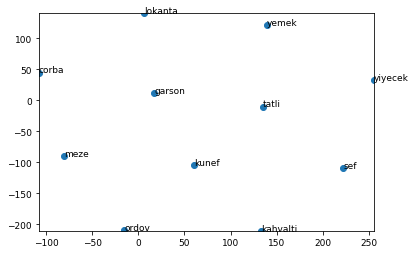

In [11]:
# MOST SIMILAR WORDS TO GIVEN WORD
word = input()
if word in doc2vec_model.wv:
    display_closestwords_tsnescatterplot(doc2vec_model, word, doc2vec_model.vector_size)
else:
    print("Not in vacobulary")

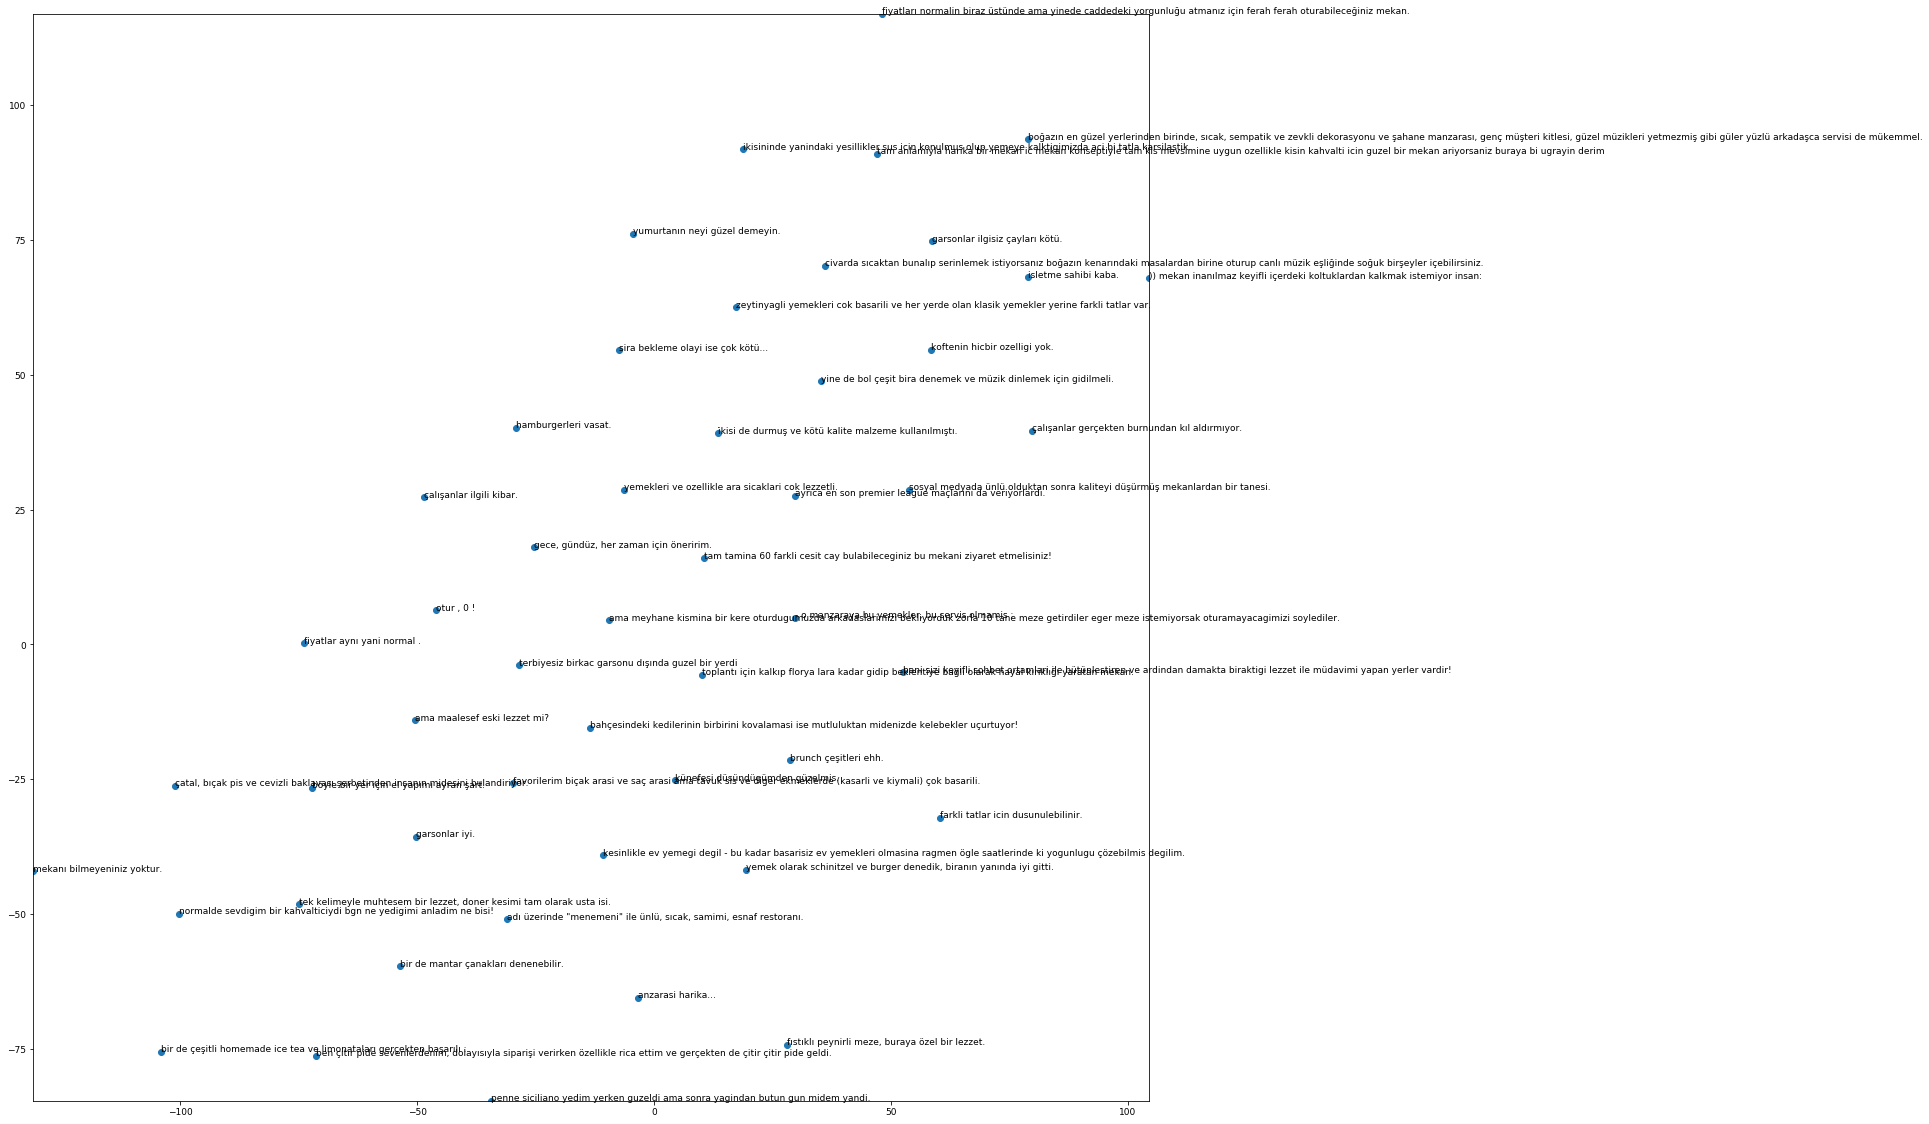

In [12]:
# PLOT DOCUMENTS WITH TSNE
arr = np.empty((0, doc2vec_model.vector_size), dtype='f')
doc_labels = []
for i in range(50):
    selected_doc_index = random.randrange(len(raw_reviews))
    doc2vec_label = "RESTAURANT_REVIEW_{}".format(selected_doc_index)
    arr = np.append(arr, np.array([doc2vec_model.docvecs["RESTAURANT_REVIEW_{}".format(i)]]), axis=0)
    doc_labels.append(raw_reviews[selected_doc_index])
    
# find tsne coords for 2 dimensions
tsne = TSNE(n_components=2, random_state=0)
np.set_printoptions(suppress=True)
Y = tsne.fit_transform(arr)
plt.figure(1, figsize=(20,20))
x_coords = Y[:, 0]
y_coords = Y[:, 1]
# display scatter plot
plt.scatter(x_coords, y_coords)

for label, x, y in zip(doc_labels, x_coords, y_coords):
    plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
plt.show()

In [13]:
review_vectors = []
for i, review in enumerate(preprocessed_reviews):
    review_vectors.append(doc2vec_model.docvecs["RESTAURANT_REVIEW_{}".format(i)])

In [14]:
# CONSTRUCT DOC2VEC SIMILARITY MATRIX
doc2vec_adjacency_matrix = 1 - pairwise_distances(review_vectors, metric="cosine")
printmd("** DOC2VEC ADJACENCY MATRIX **")
printmd("** Shape of adjacency the matrix: ** {}".format(doc2vec_adjacency_matrix.shape))
print(doc2vec_adjacency_matrix)

** DOC2VEC ADJACENCY MATRIX **

** Shape of adjacency the matrix: ** (1228, 1228)

[[ 1.          0.3785274  -0.04220355 ...  0.17803276  0.33693534
   0.43802488]
 [ 0.3785274   1.         -0.07357073 ...  0.4072857   0.83097744
   0.8377431 ]
 [-0.04220355 -0.07357073  1.         ... -0.04975724 -0.18678224
  -0.23294699]
 ...
 [ 0.17803276  0.40728563 -0.04975724 ...  1.          0.36507726
   0.45081377]
 [ 0.3369354   0.83097756 -0.18678224 ...  0.36507726  1.
   0.84638363]
 [ 0.43802494  0.83774304 -0.23294699 ...  0.45081383  0.8463835
   1.        ]]


In [15]:
# CREATE GRAPHS USING SIMILARITY MATRICES
def create_graph(adjacency_matrix, threshold=0.1, subsample_size=0):
    rows, cols = np.where(adjacency_matrix >= threshold)
    edges = zip(rows.tolist(), cols.tolist())
    gr = nx.Graph()
    gr.add_edges_from(edges)
    if subsample_size > 0:
        return gr.subgraph(list(range(subsample_size)))
    else:
        return gr

def get_meaningful_subgraph(G):
    G2 = G.subgraph(random.sample(list(range(0, len(G.nodes))), 20))
    degrees = G2.degree()
    to_keep = [k for k, v in degrees if v > 2]
    G3 = G2.subgraph(to_keep)
    return G3.subgraph(to_keep)

In [16]:
# CREATE TF-IDF SIMILARITY GRAPH
tfidf_graph = create_graph(tfidf_adjacency_matrix, threshold=0.2)

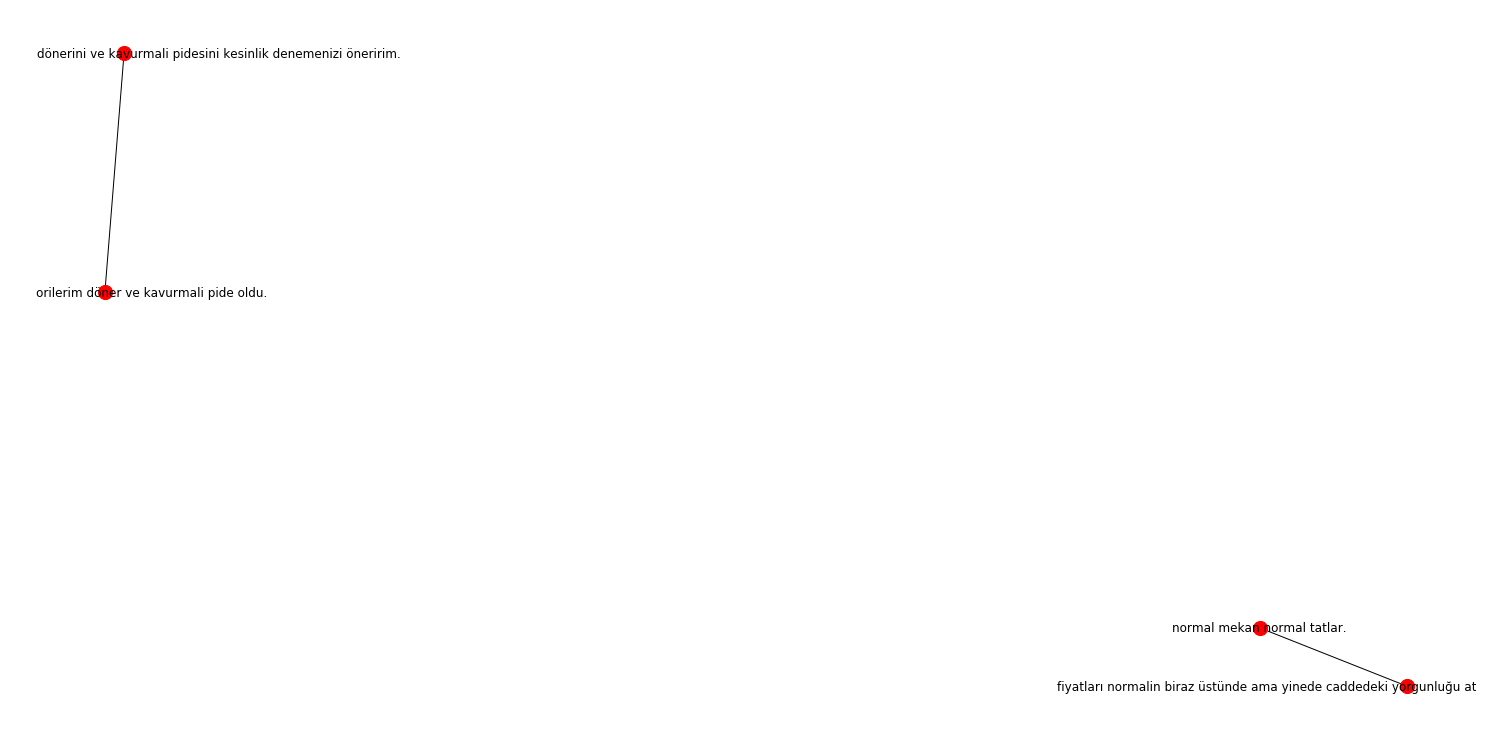

In [17]:
# PLOT SAMPLES IN TF-IDF SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(tfidf_graph)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(20,10))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

In [18]:
# CREATE AND PLOT DOC2VEC SIMILARITY GRAPH
doc2vec_graph = create_graph(doc2vec_adjacency_matrix, threshold=0.8)

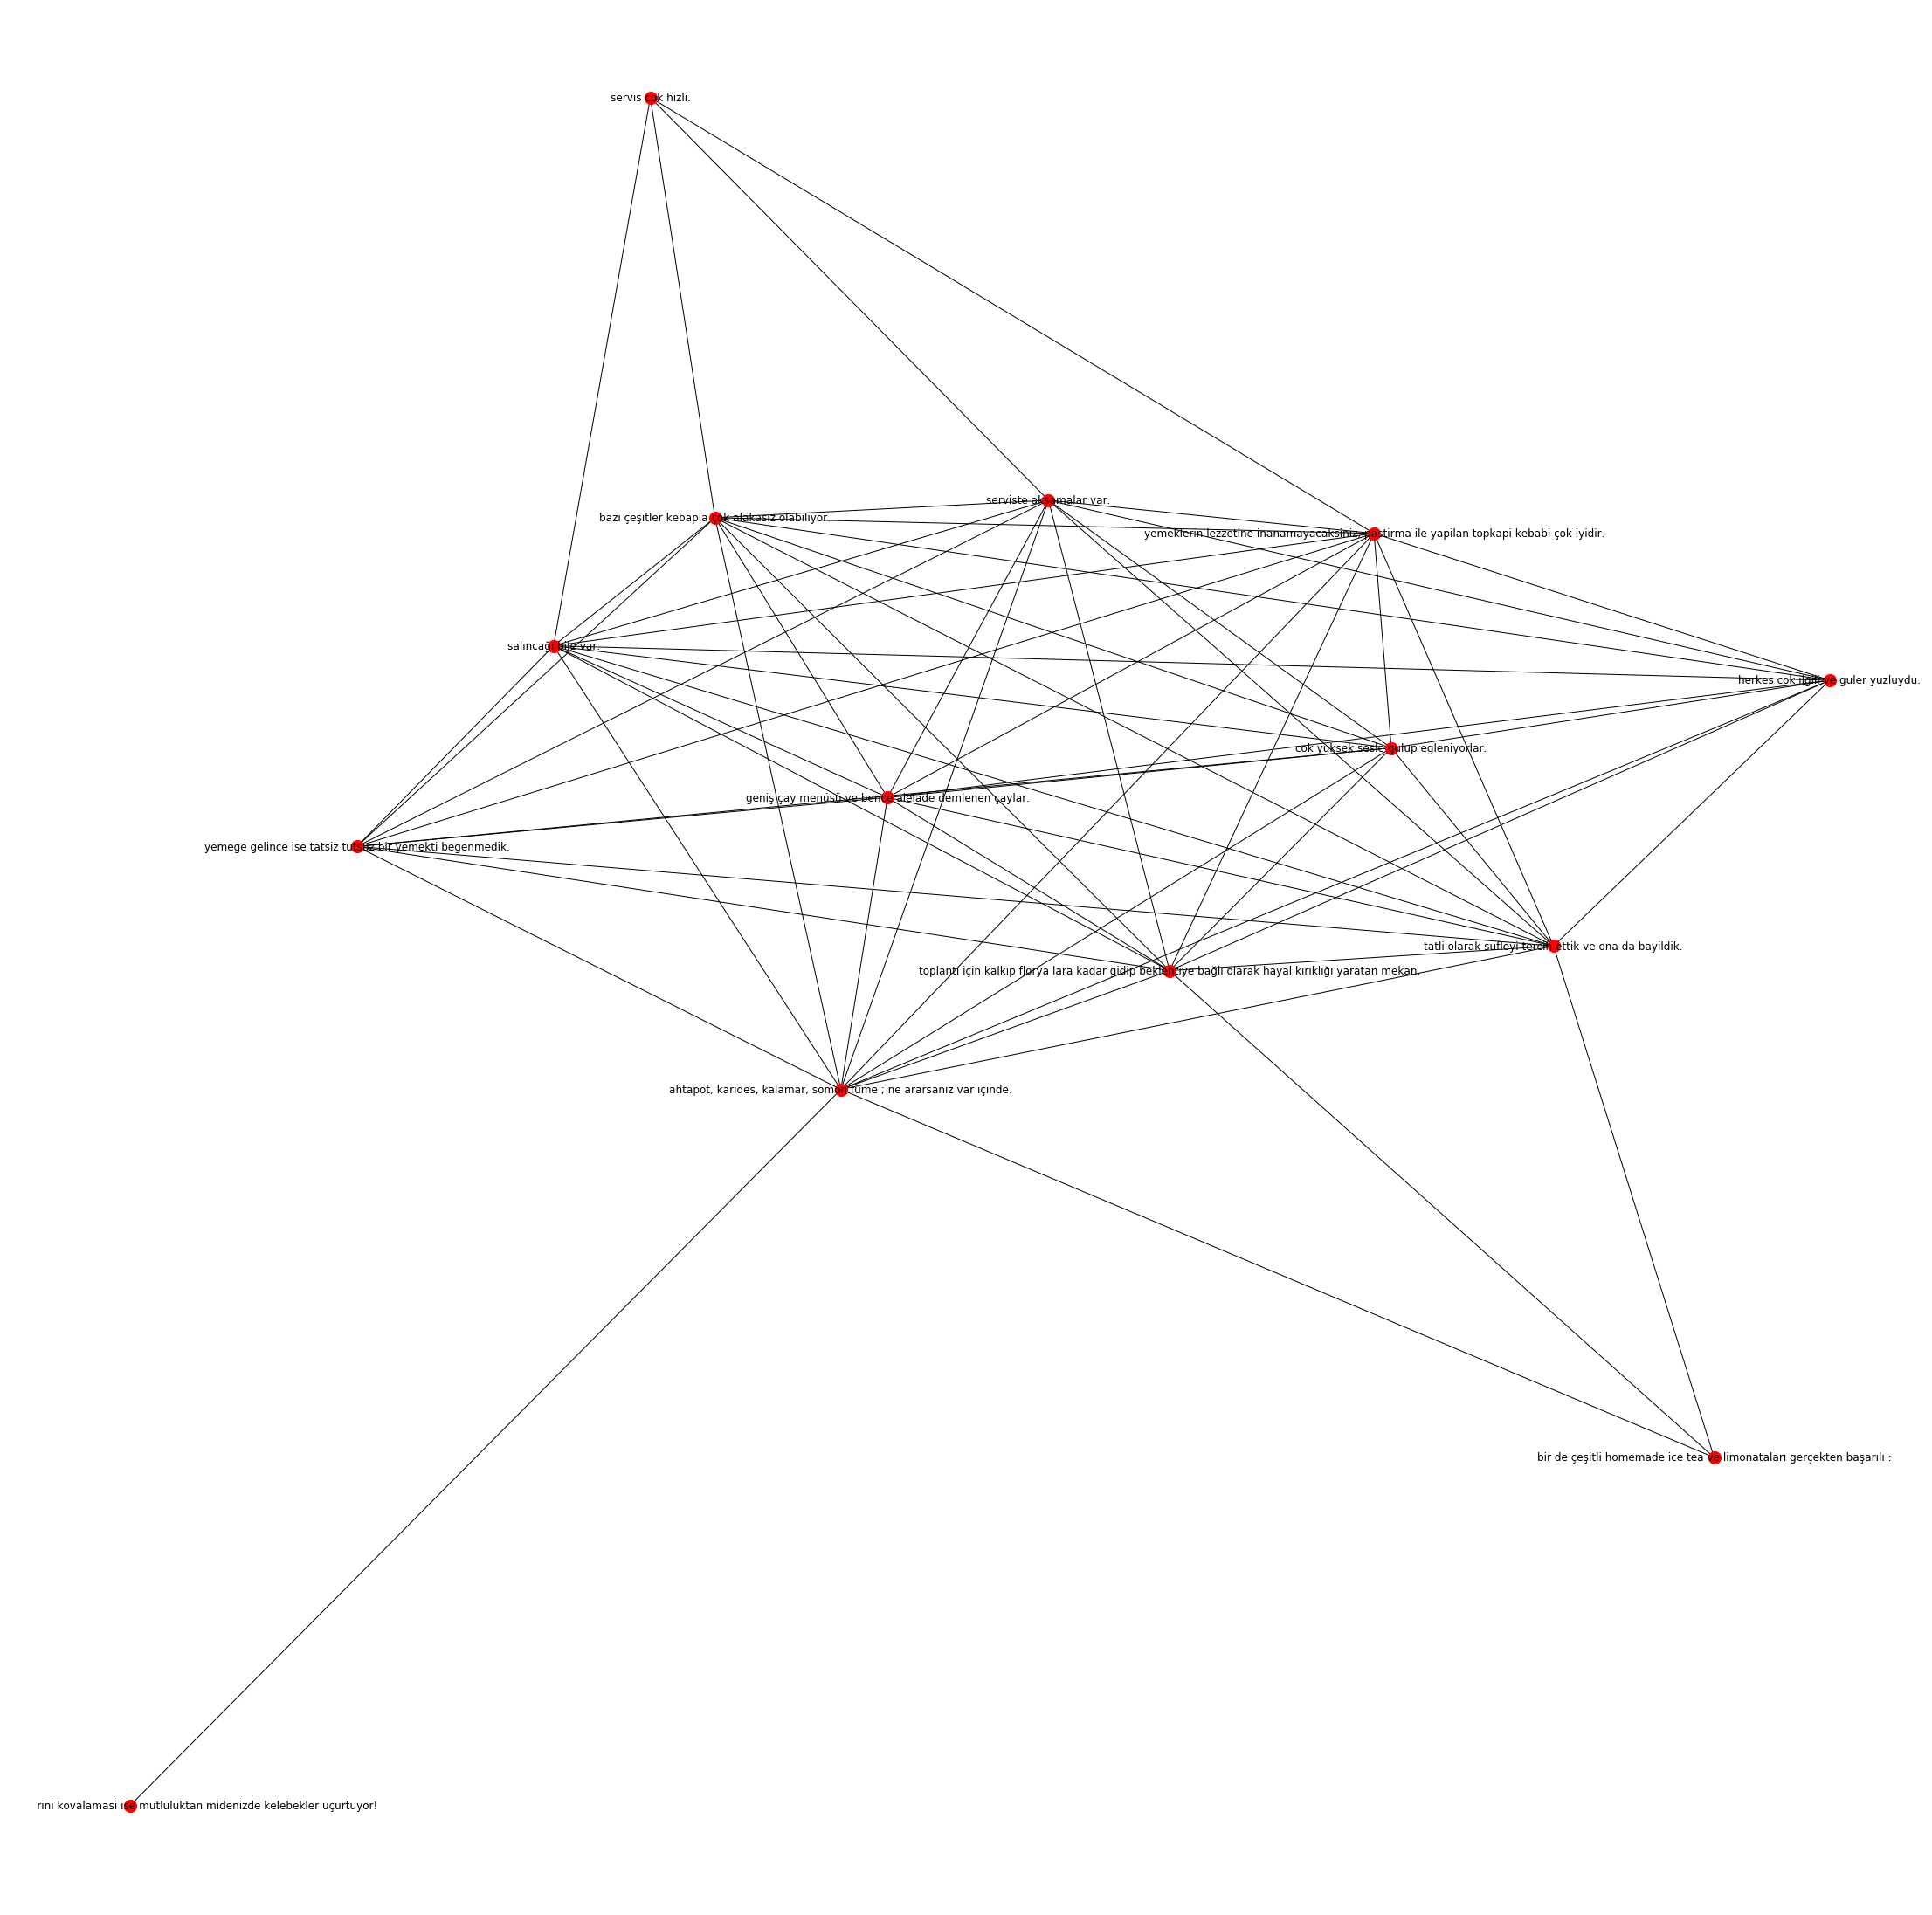

In [19]:
# PLOT SAMPLES IN DOC2VEC SIMILARITY GRAPH
subsample_graph = get_meaningful_subgraph(doc2vec_graph)
pos = nx.spring_layout(subsample_graph)
plt.figure(1, figsize=(30,30))
nx.draw(subsample_graph, pos=pos, node_size=200, labels={i: raw_reviews[i] for i in subsample_graph.nodes}, with_labels=True)
plt.show()

** METHOD: TF-IDF ** 


** Threshold: ** 0.1

** Average degree count ** 59.21172638436482

** Number of nodes without connection ** 8

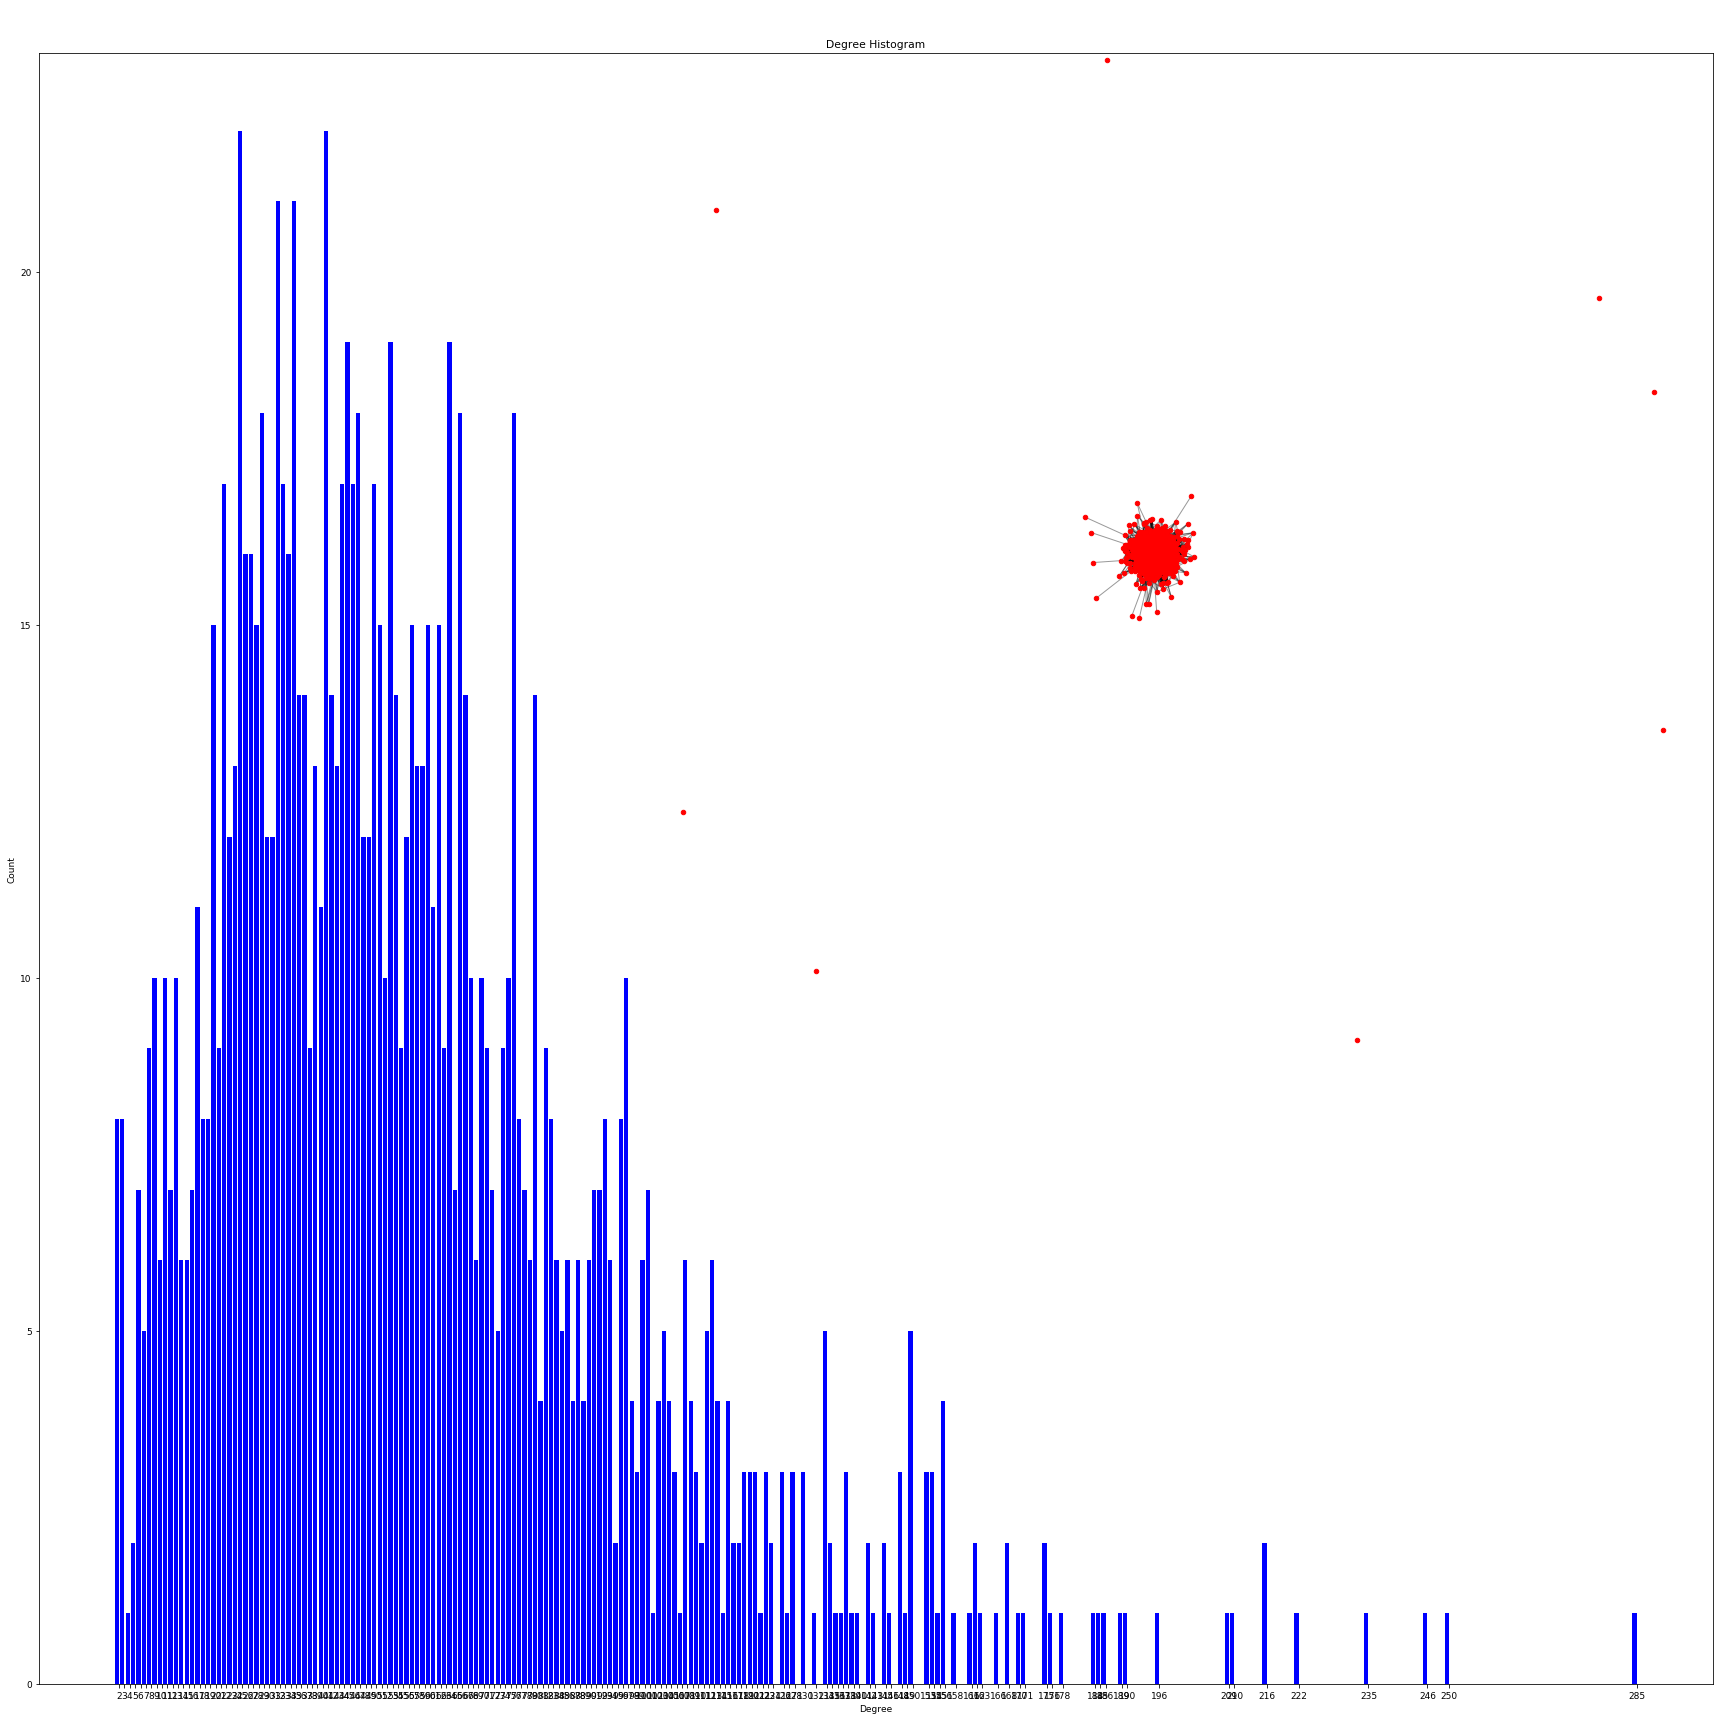

** Threshold: ** 0.2

** Average degree count ** 16.309446254071663

** Number of nodes without connection ** 23

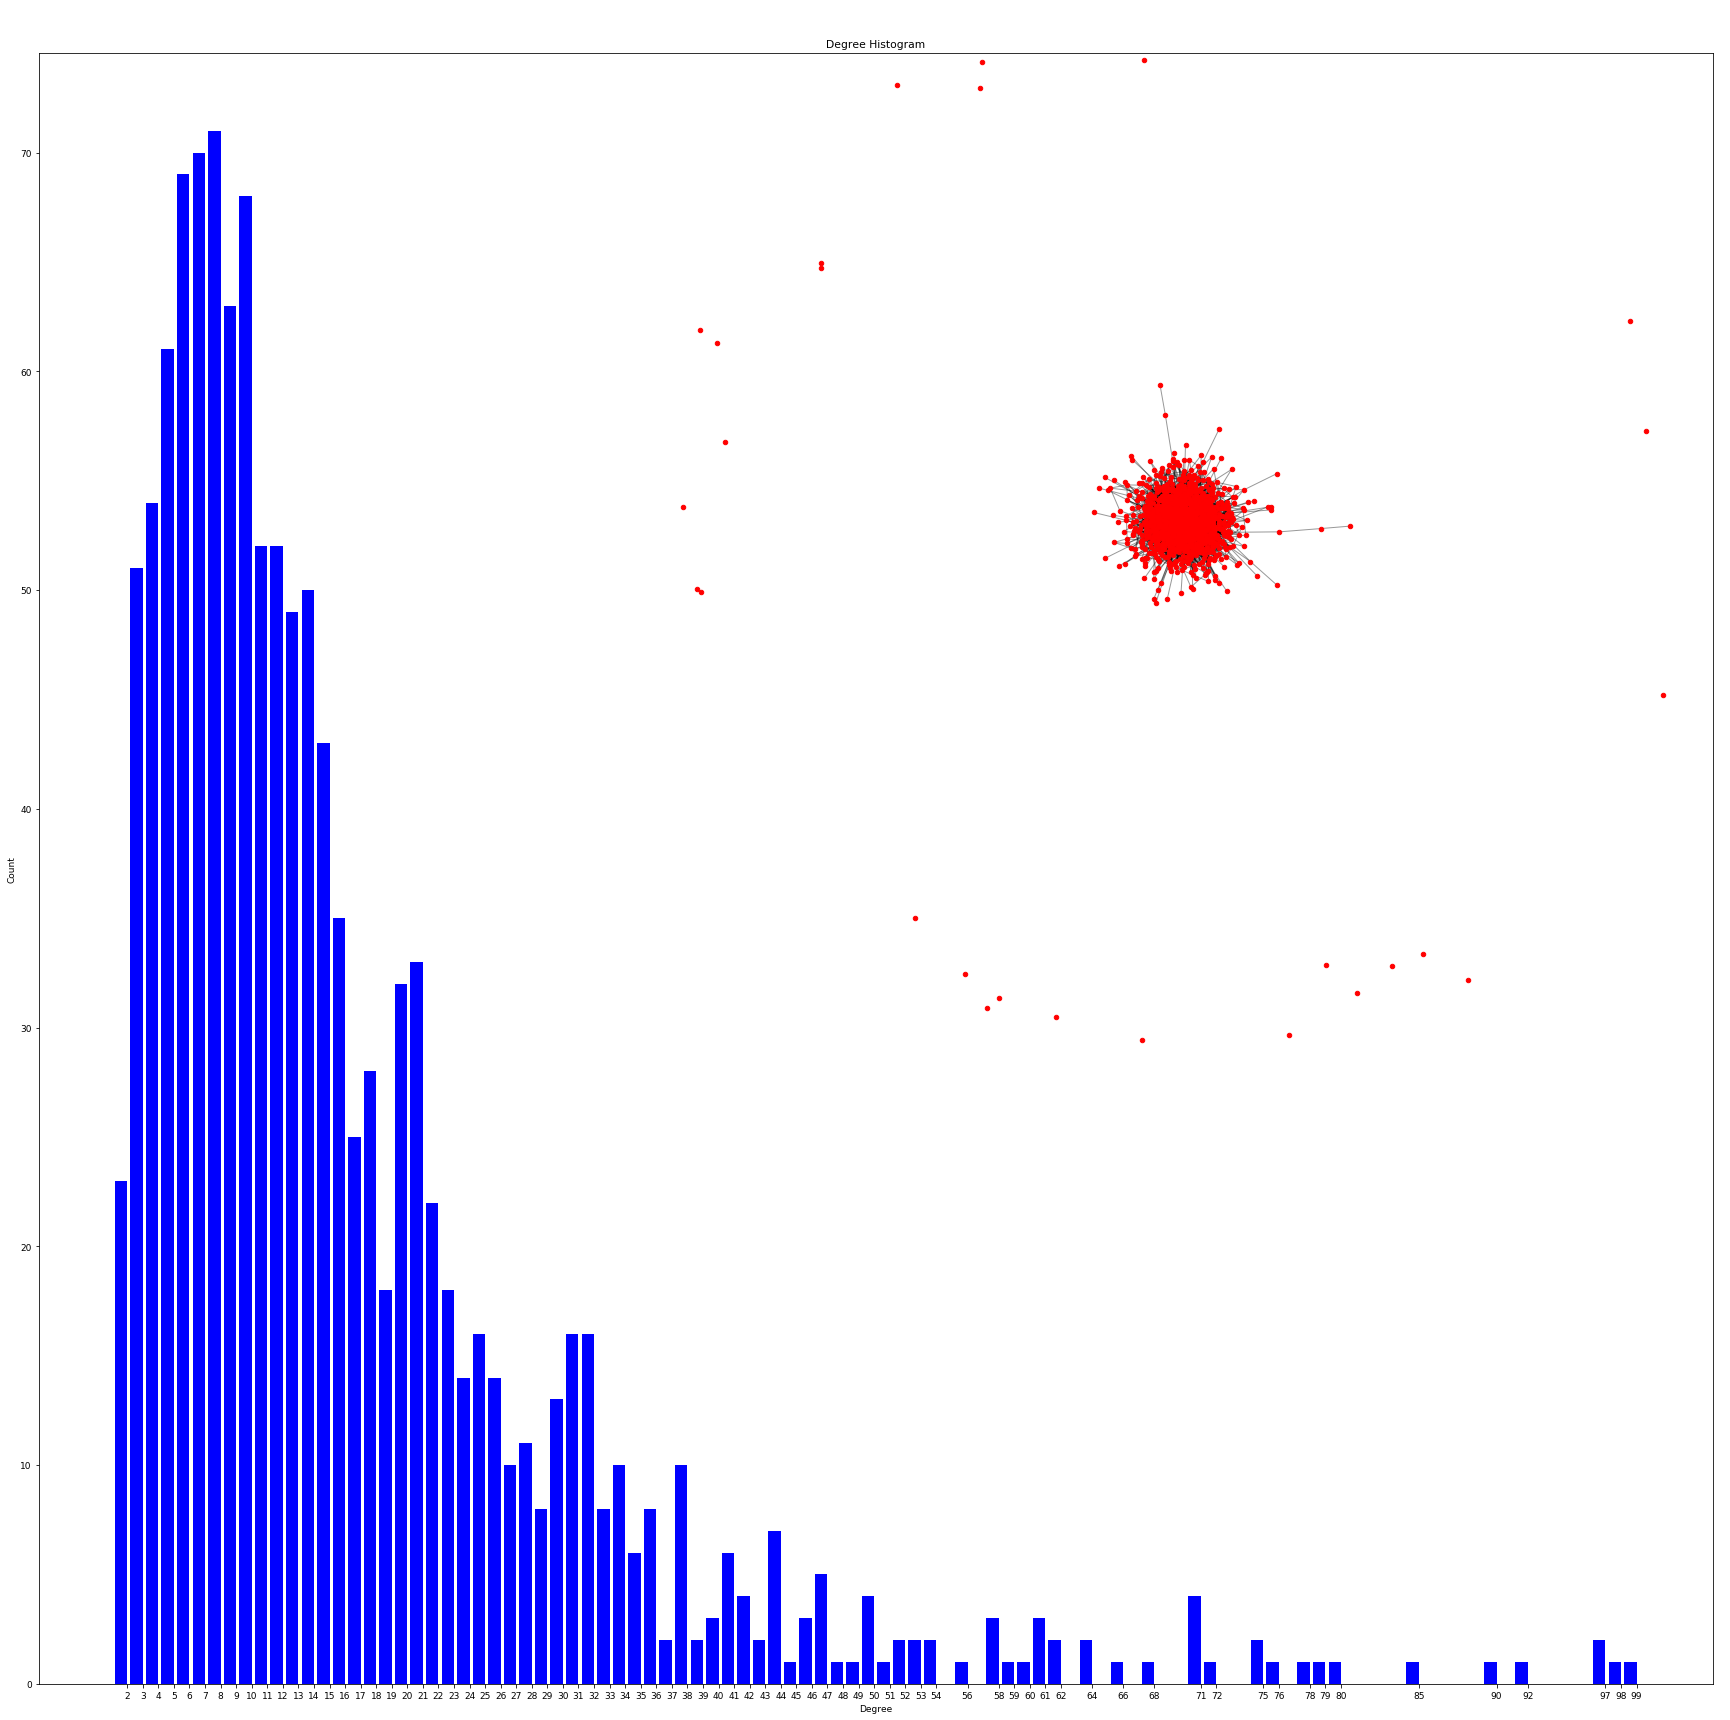

** Threshold: ** 0.3

** Average degree count ** 6.254071661237785

** Number of nodes without connection ** 260

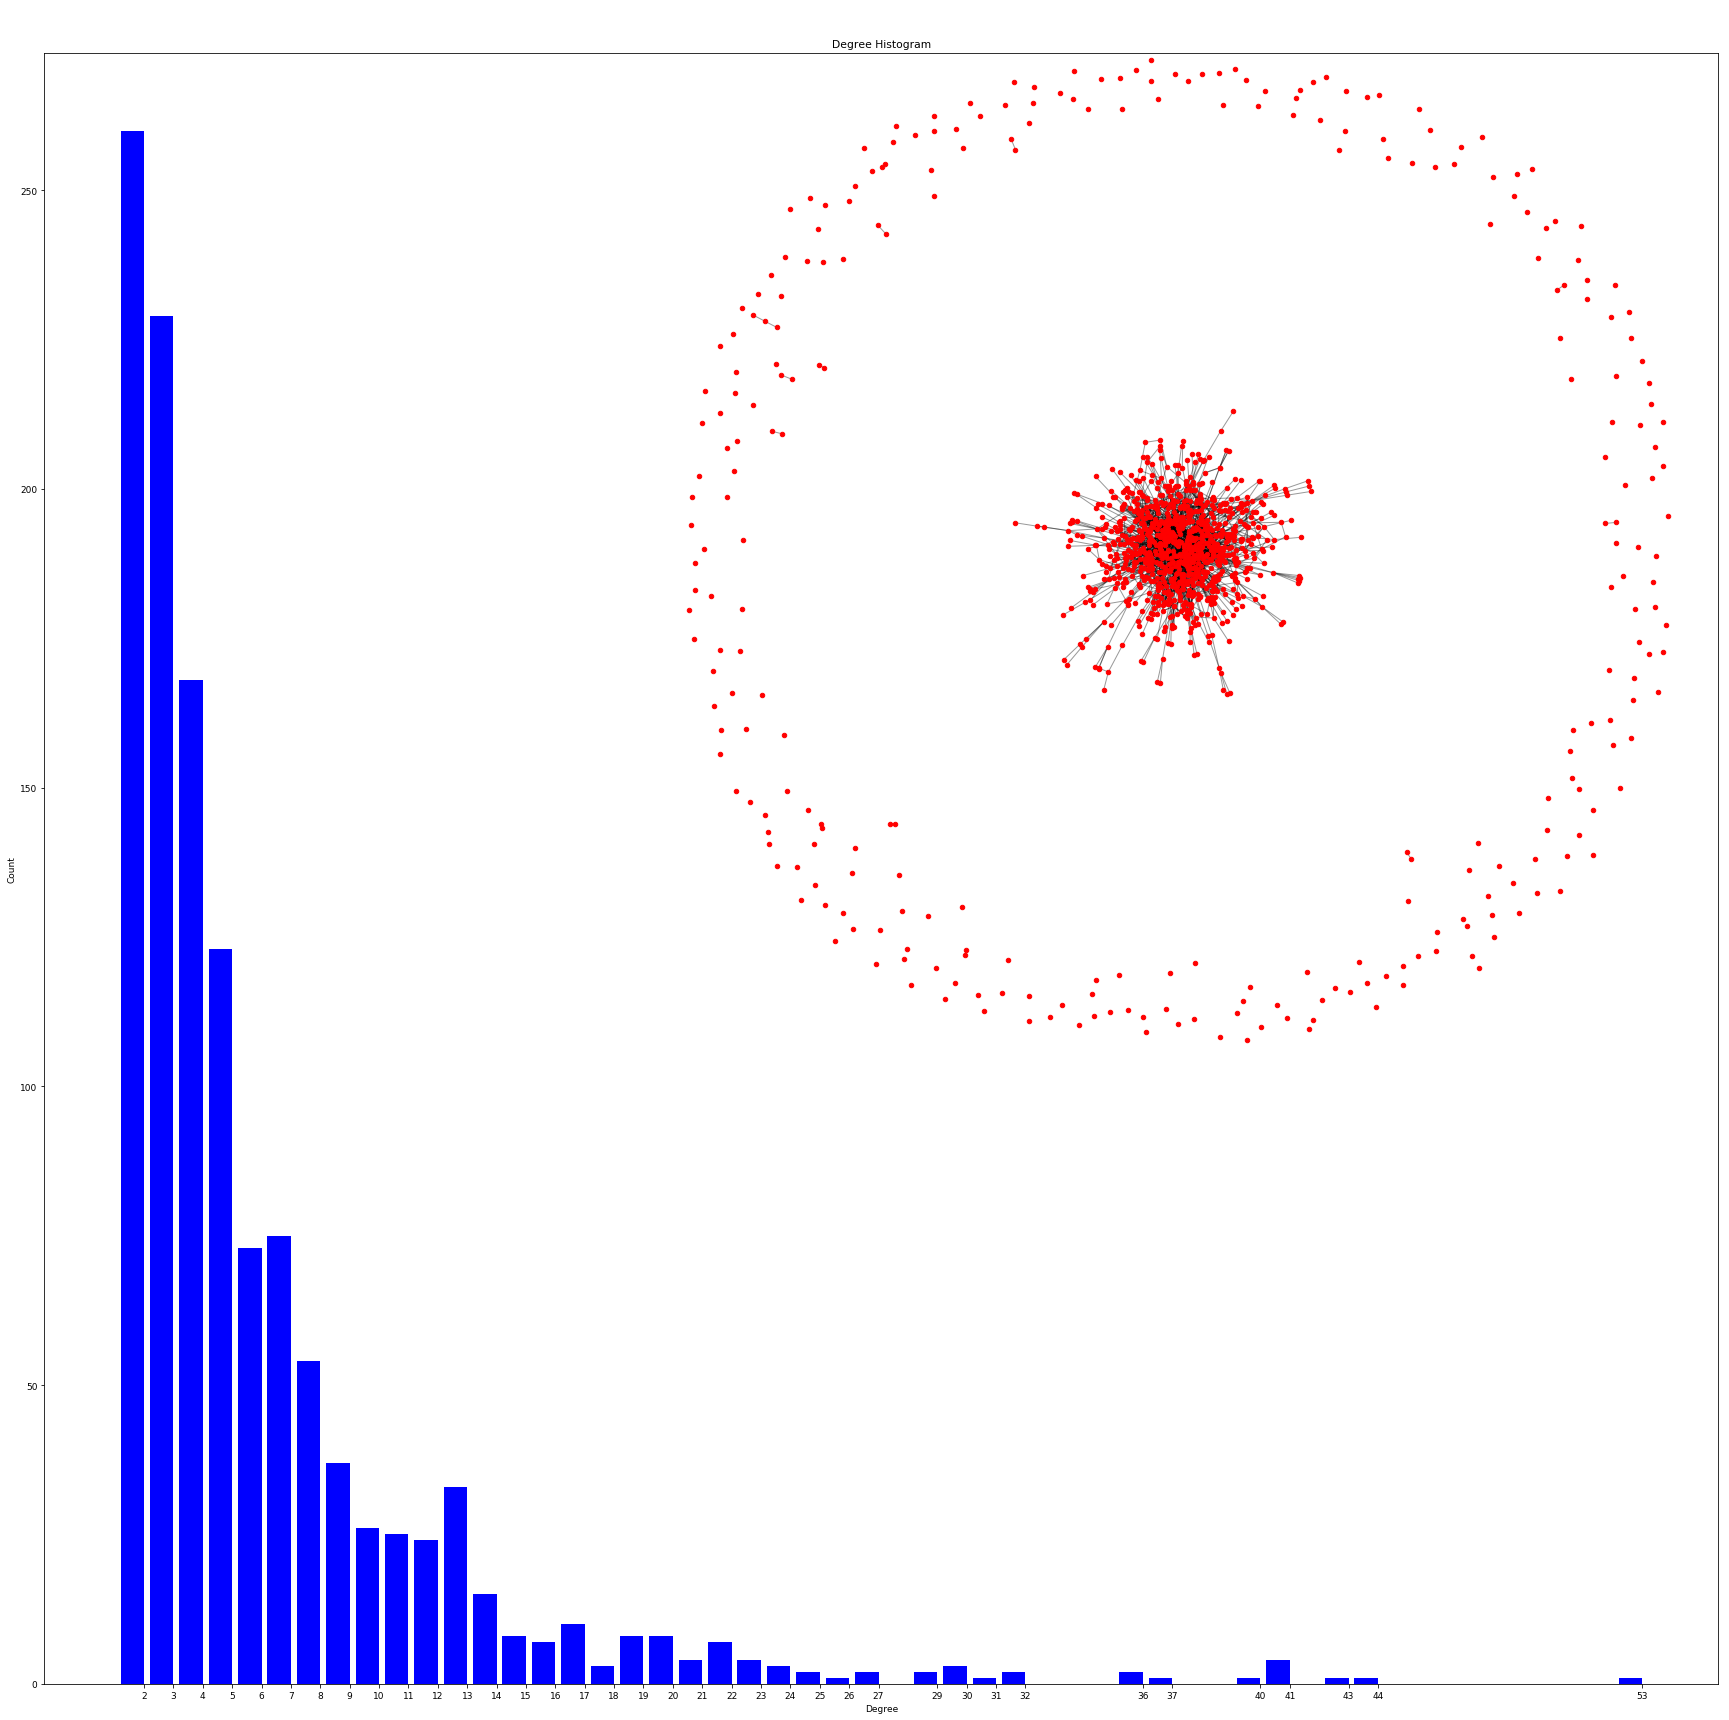

** Threshold: ** 0.4

** Average degree count ** 3.519543973941368

** Number of nodes without connection ** 638

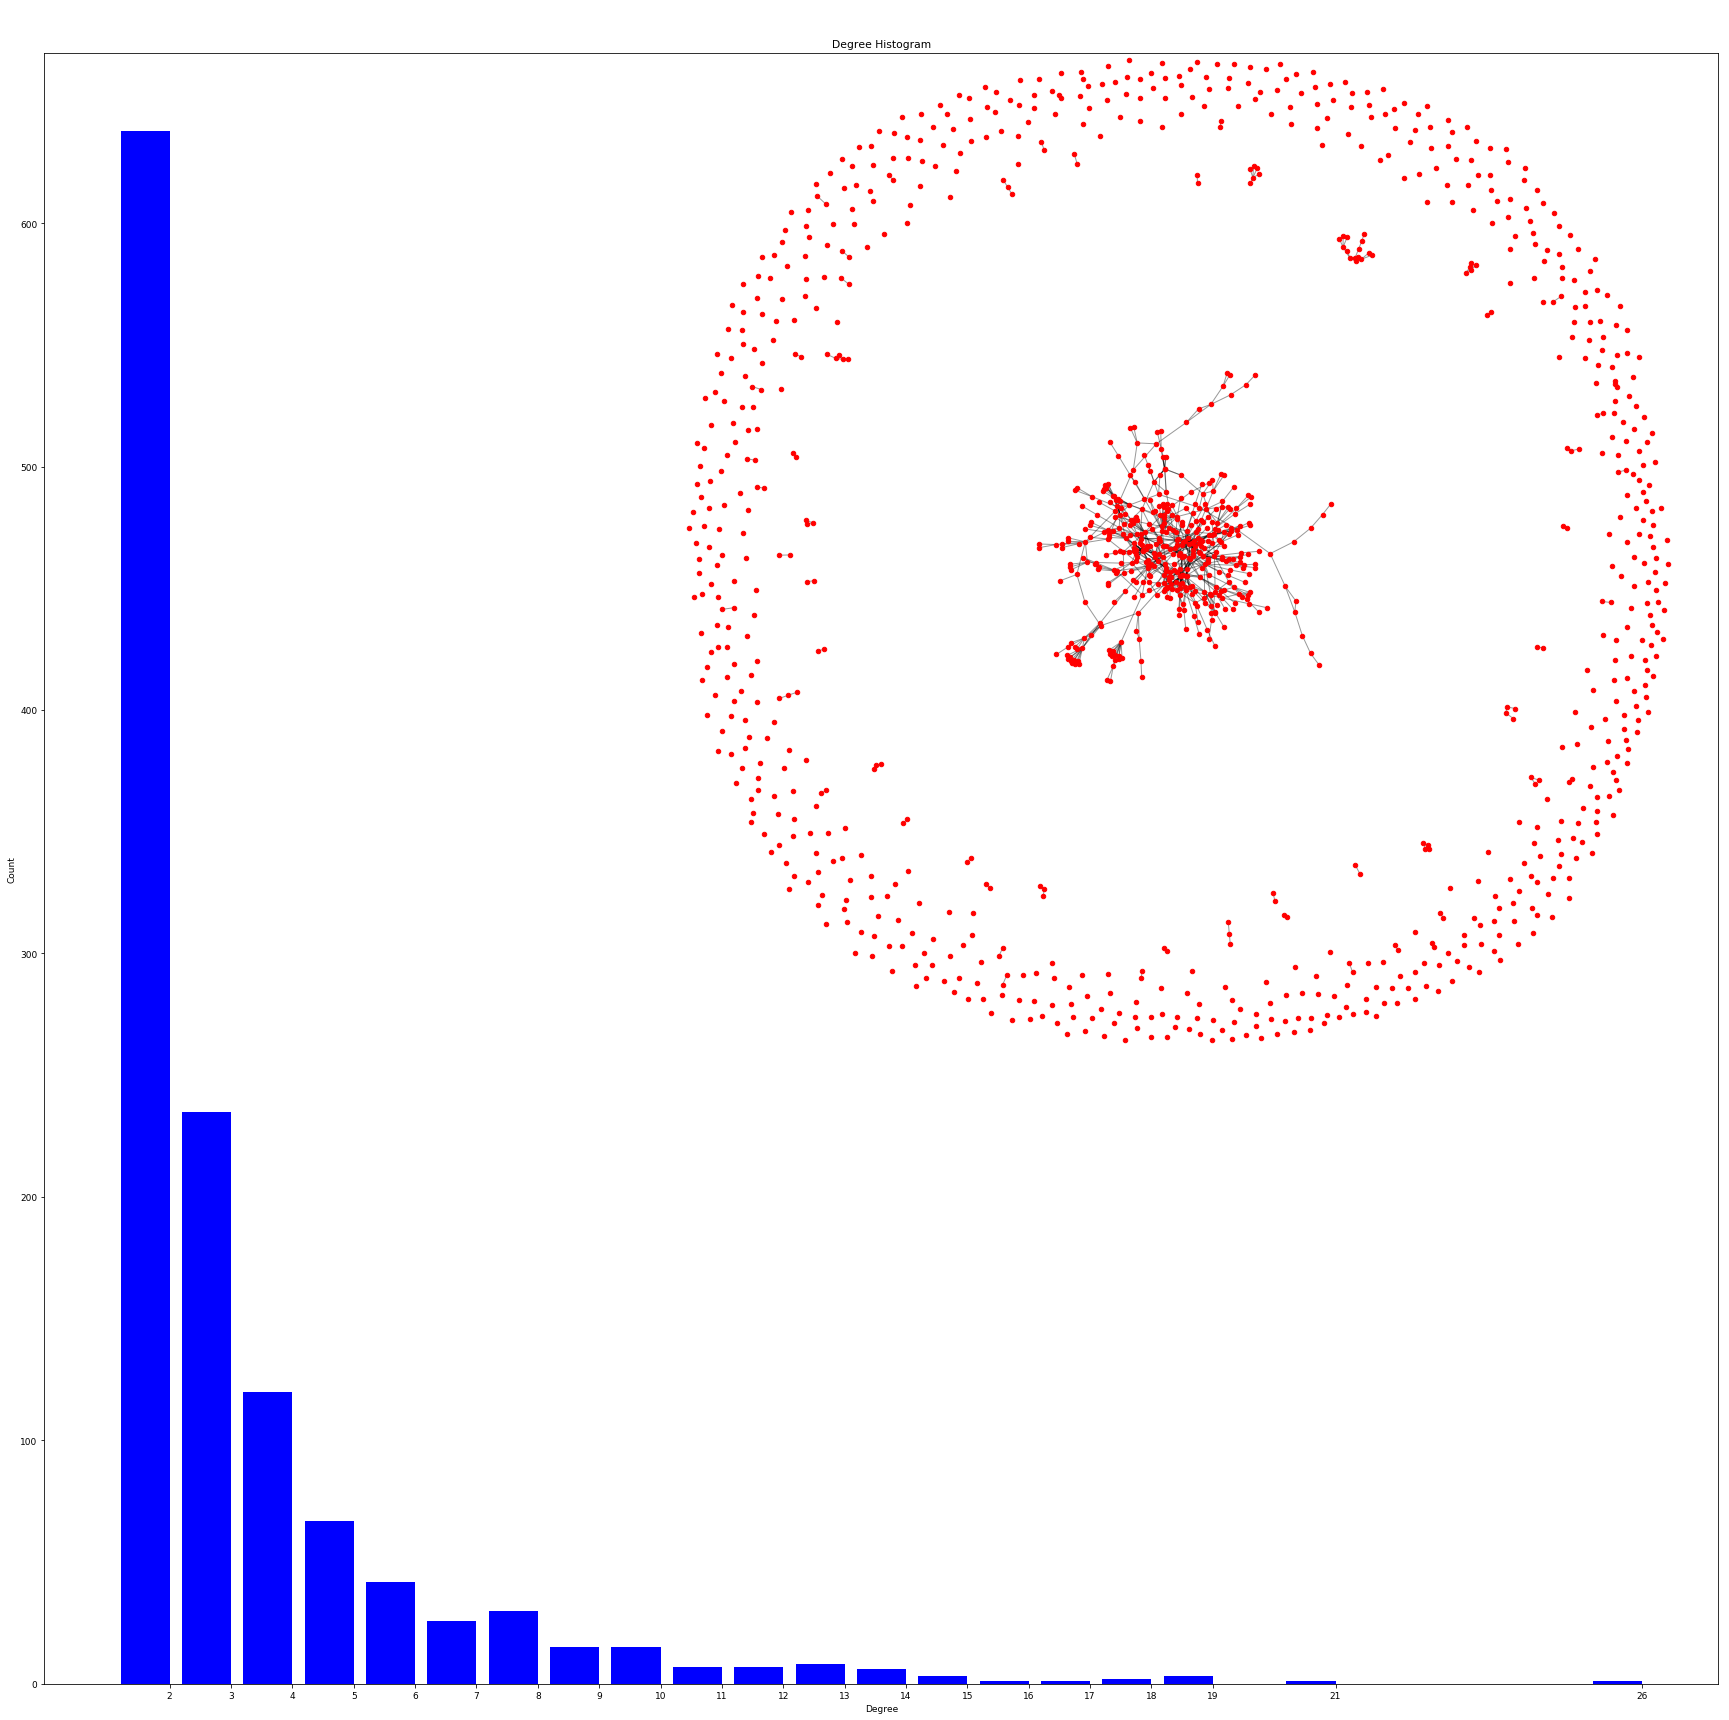

** METHOD: DOC2VEC ** 


** Threshold: ** 0.5

** Average degree count ** 701.4560260586319

** Number of nodes without connection ** 25

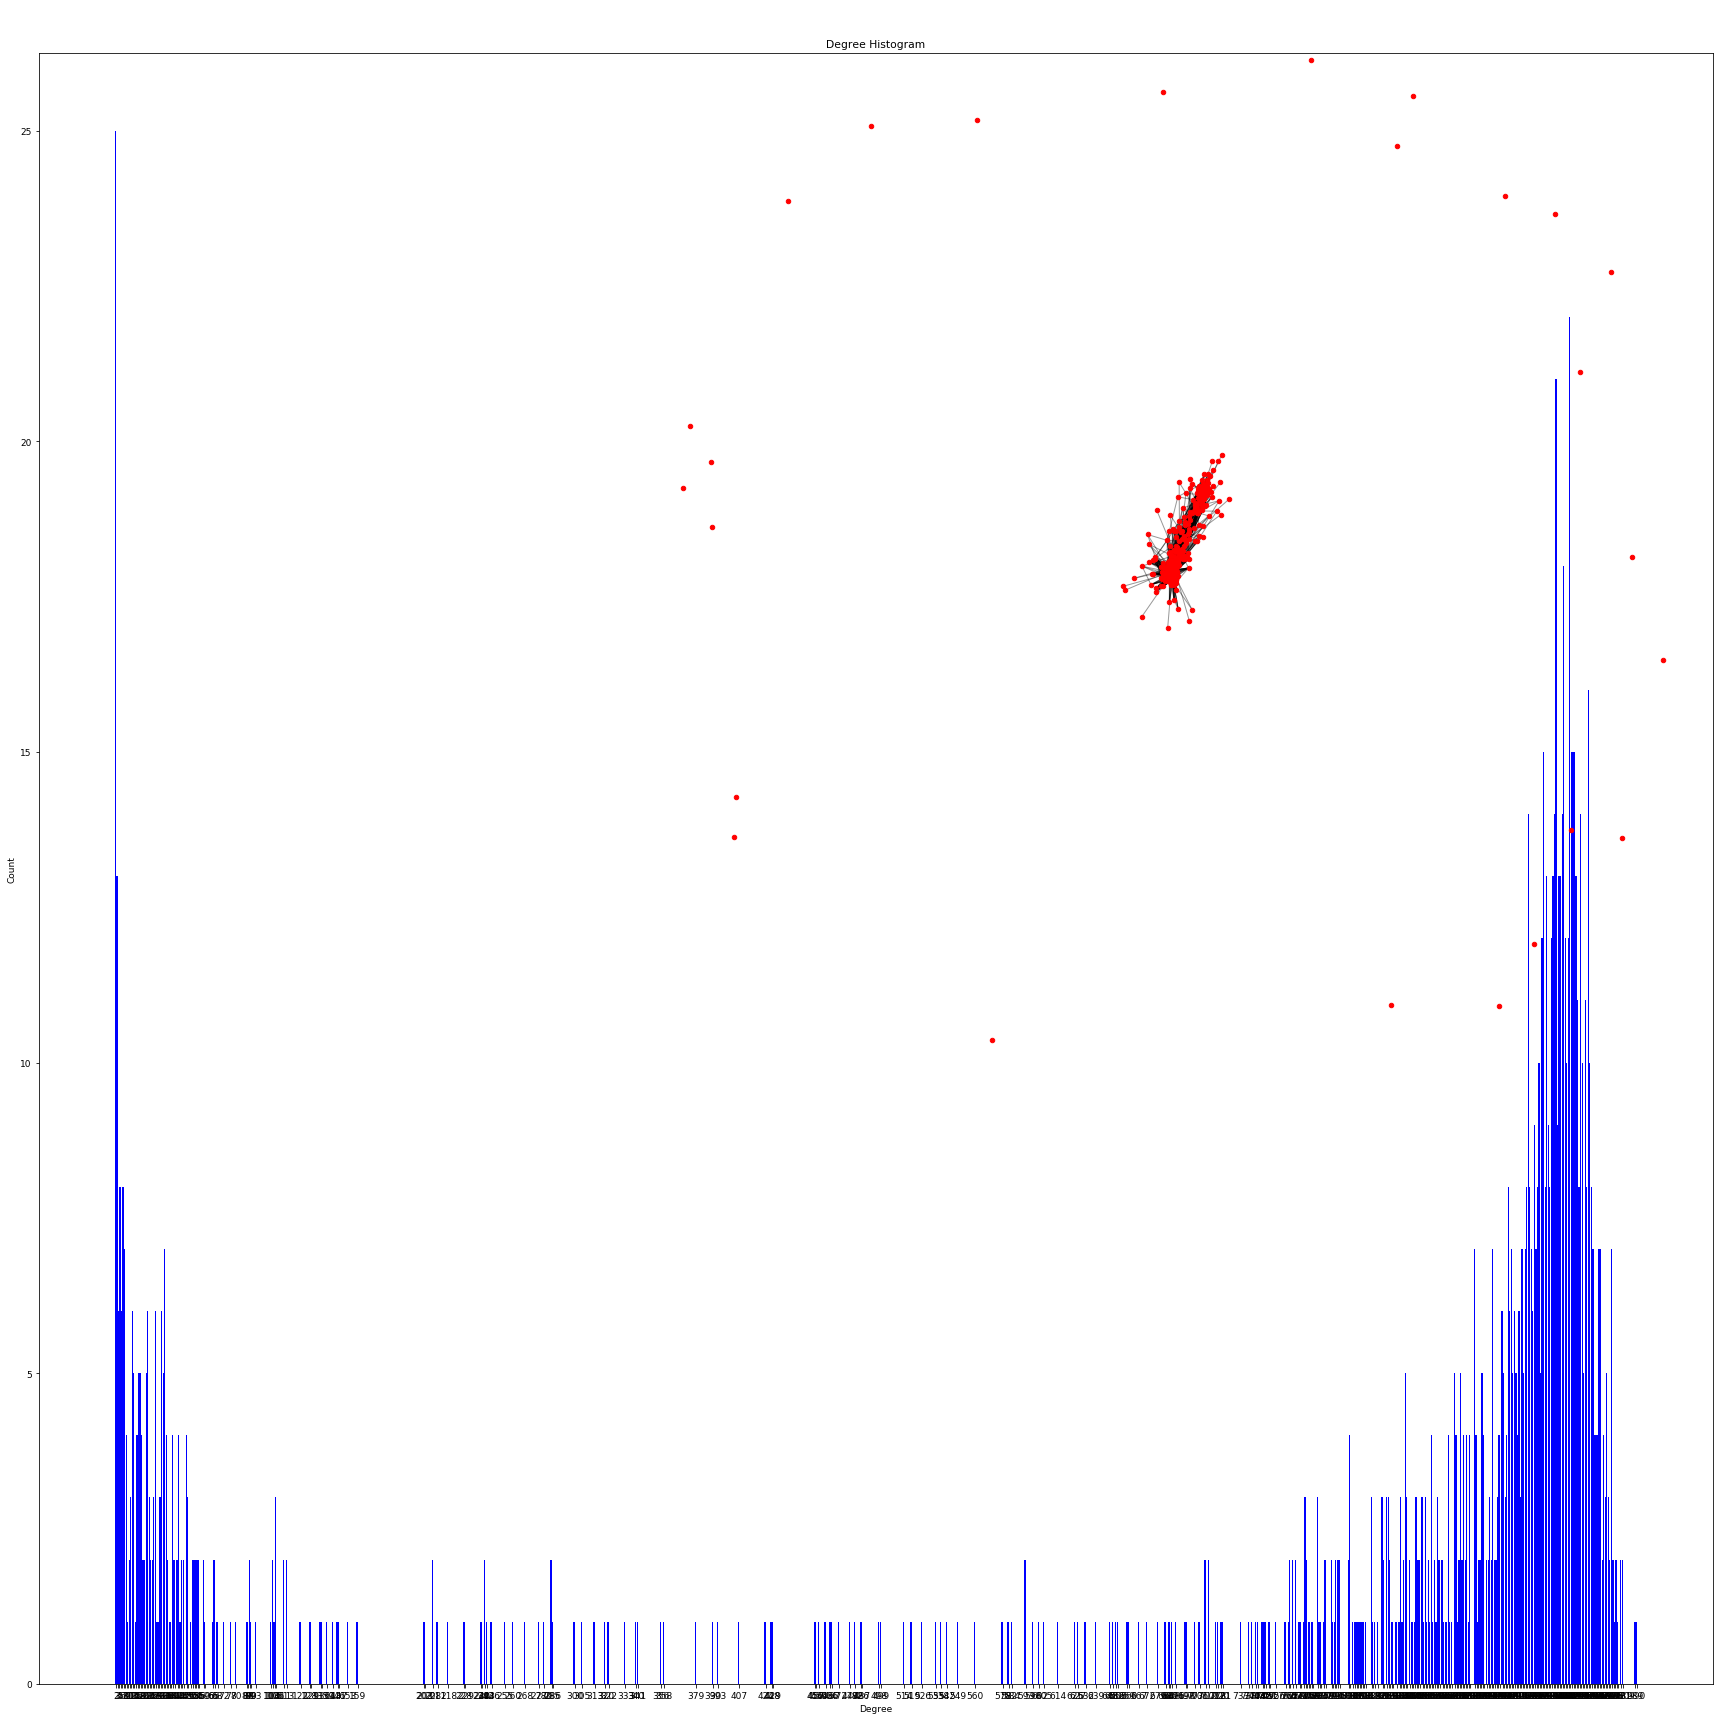

** Threshold: ** 0.6

** Average degree count ** 573.2605863192182

** Number of nodes without connection ** 83

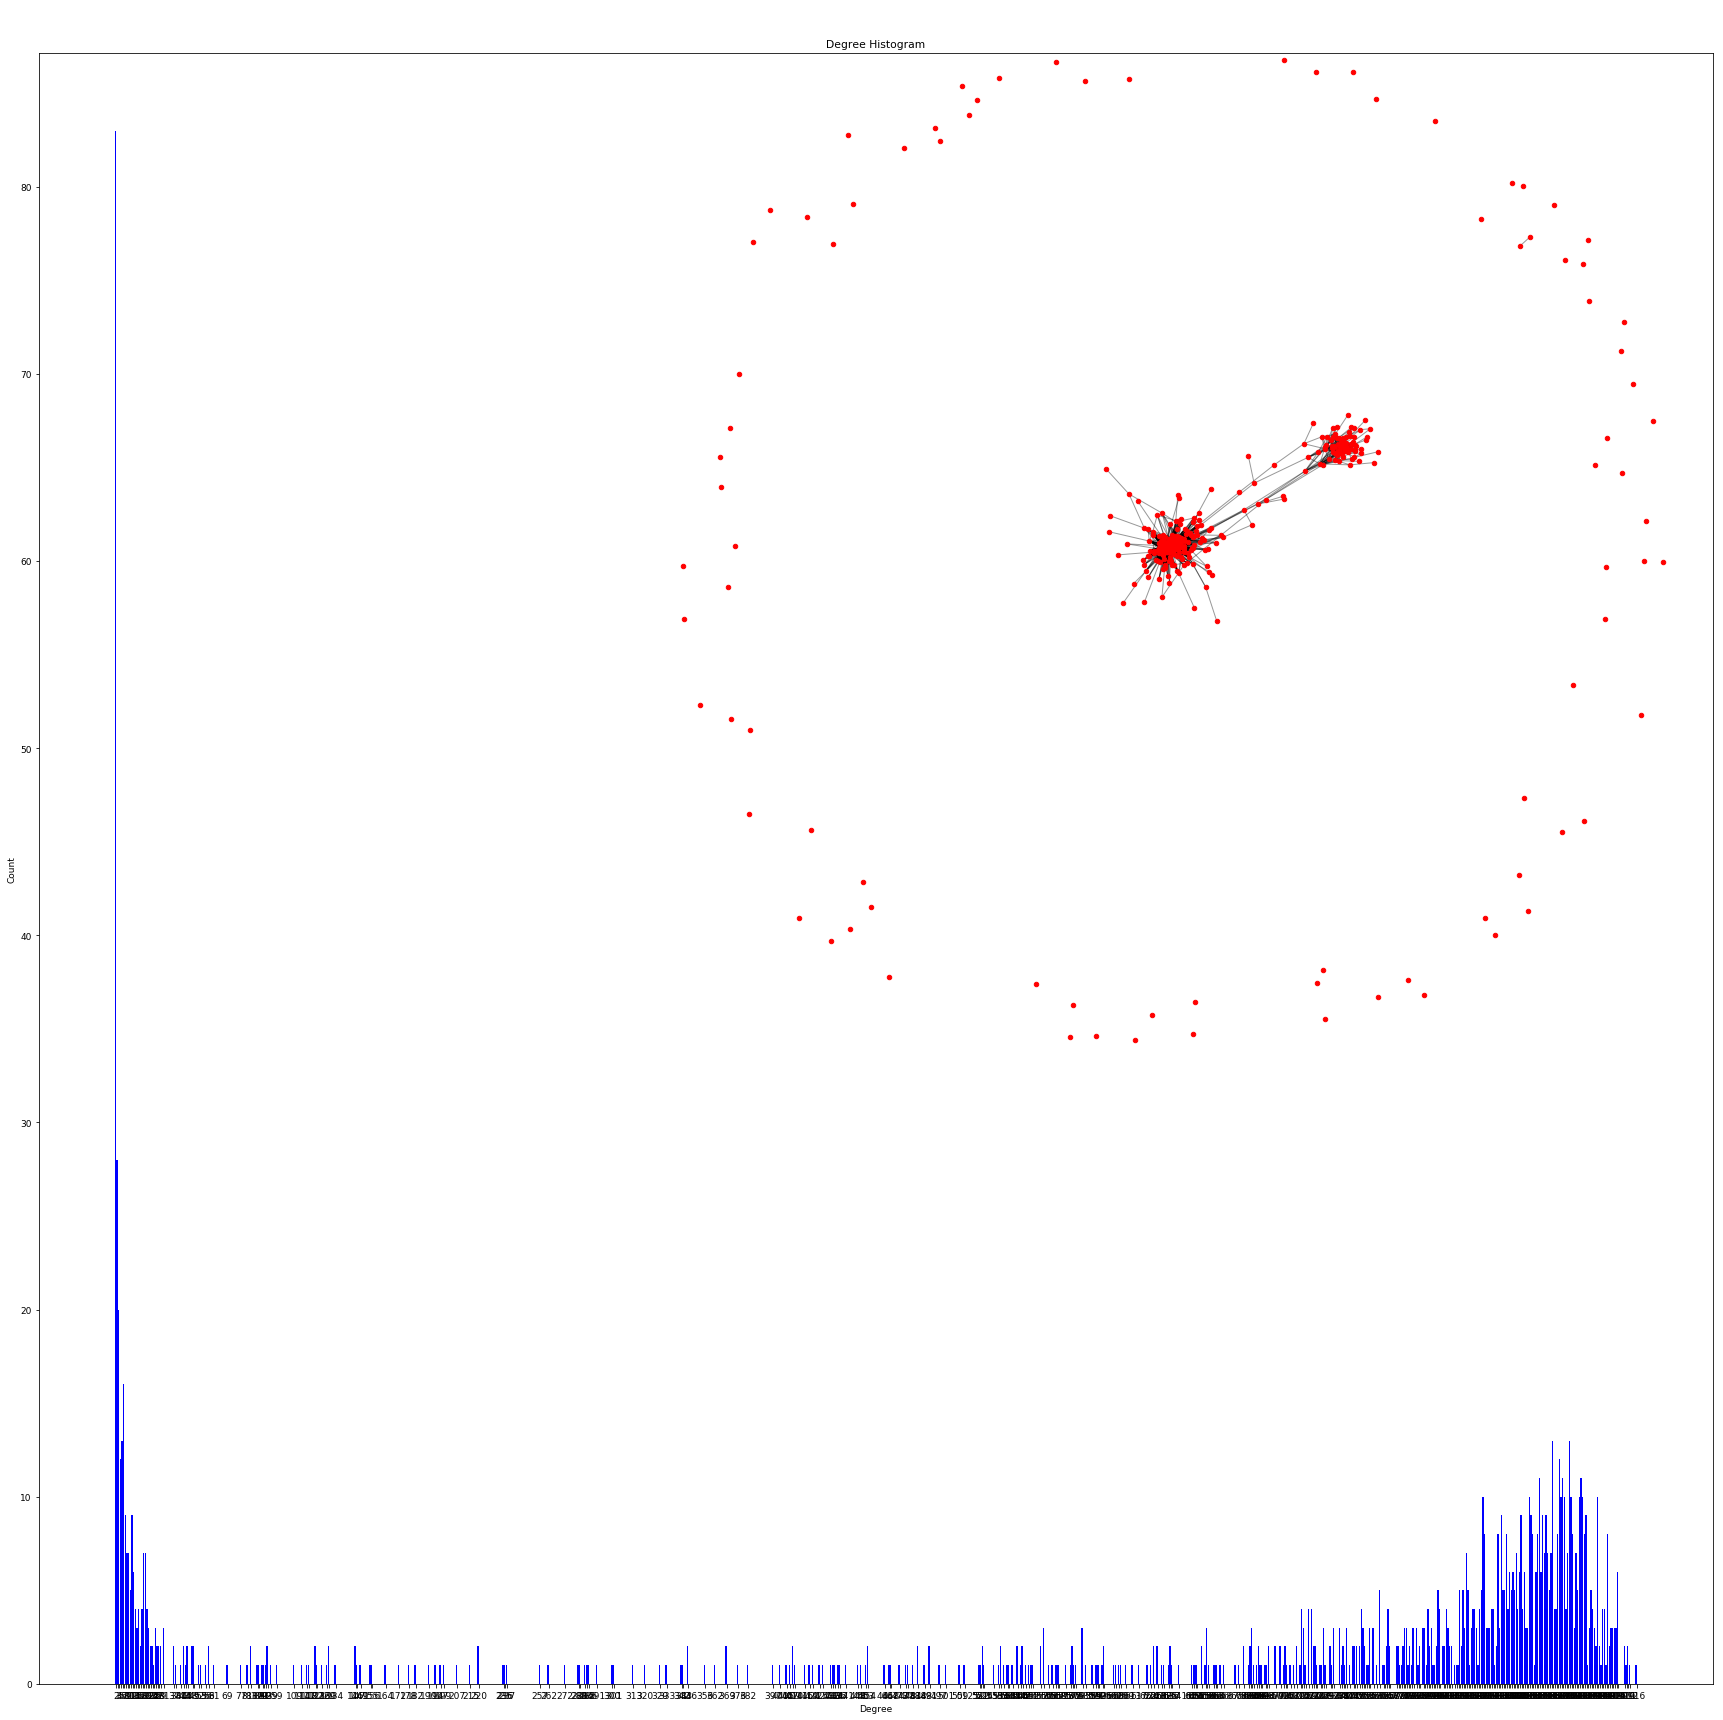

** Threshold: ** 0.7

** Average degree count ** 406.98208469055373

** Number of nodes without connection ** 226

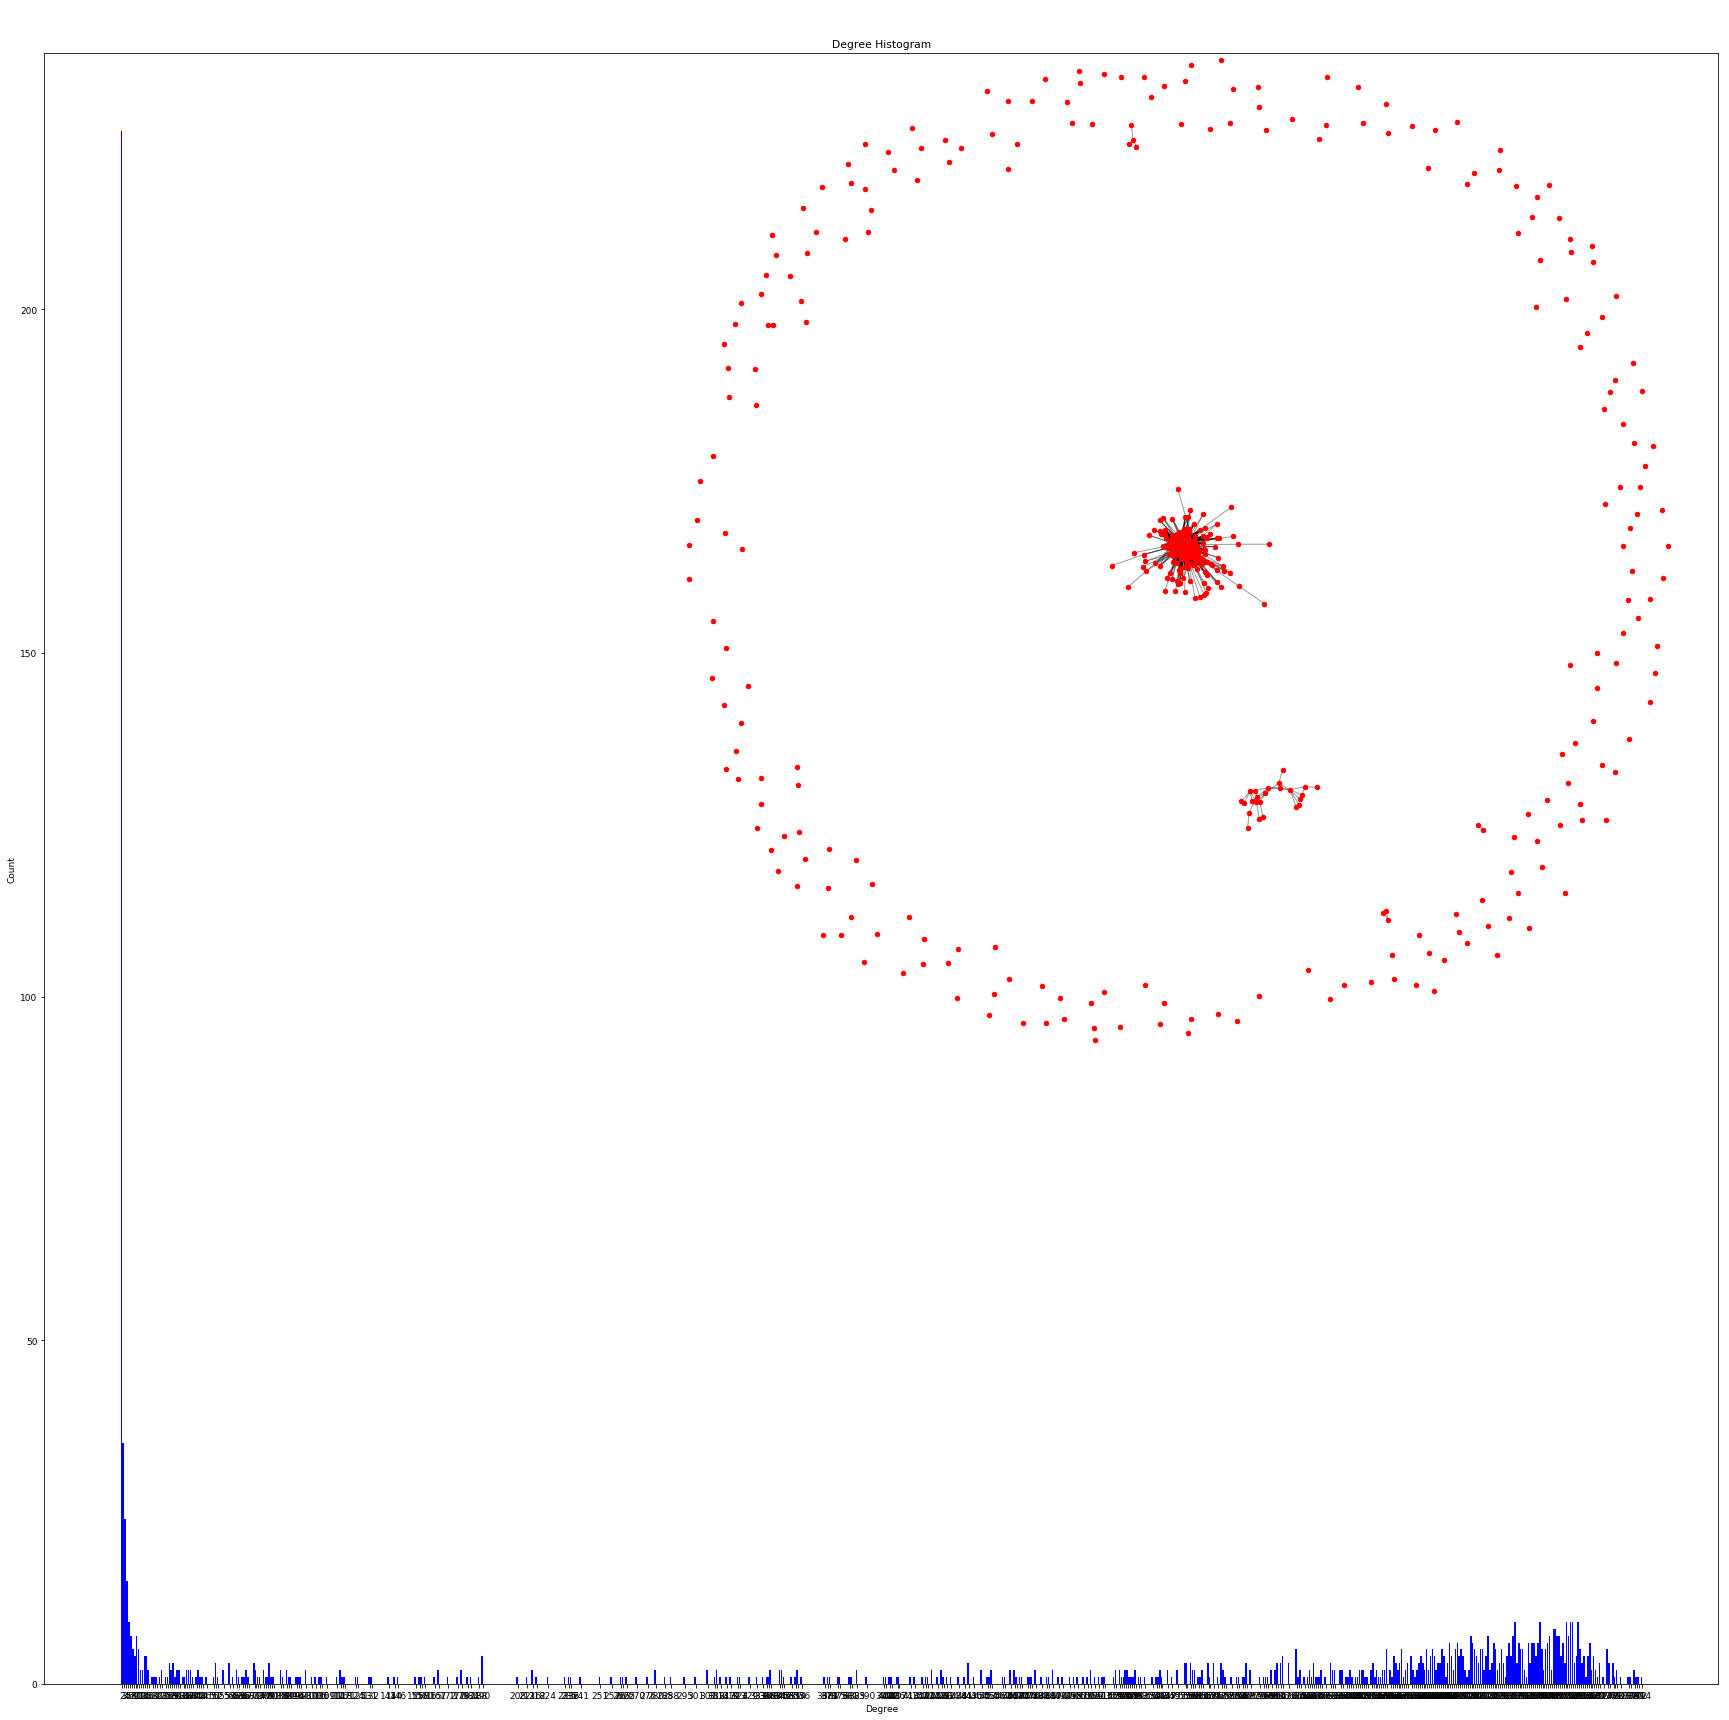

** Threshold: ** 0.8

** Average degree count ** 227.65635179153094

** Number of nodes without connection ** 417

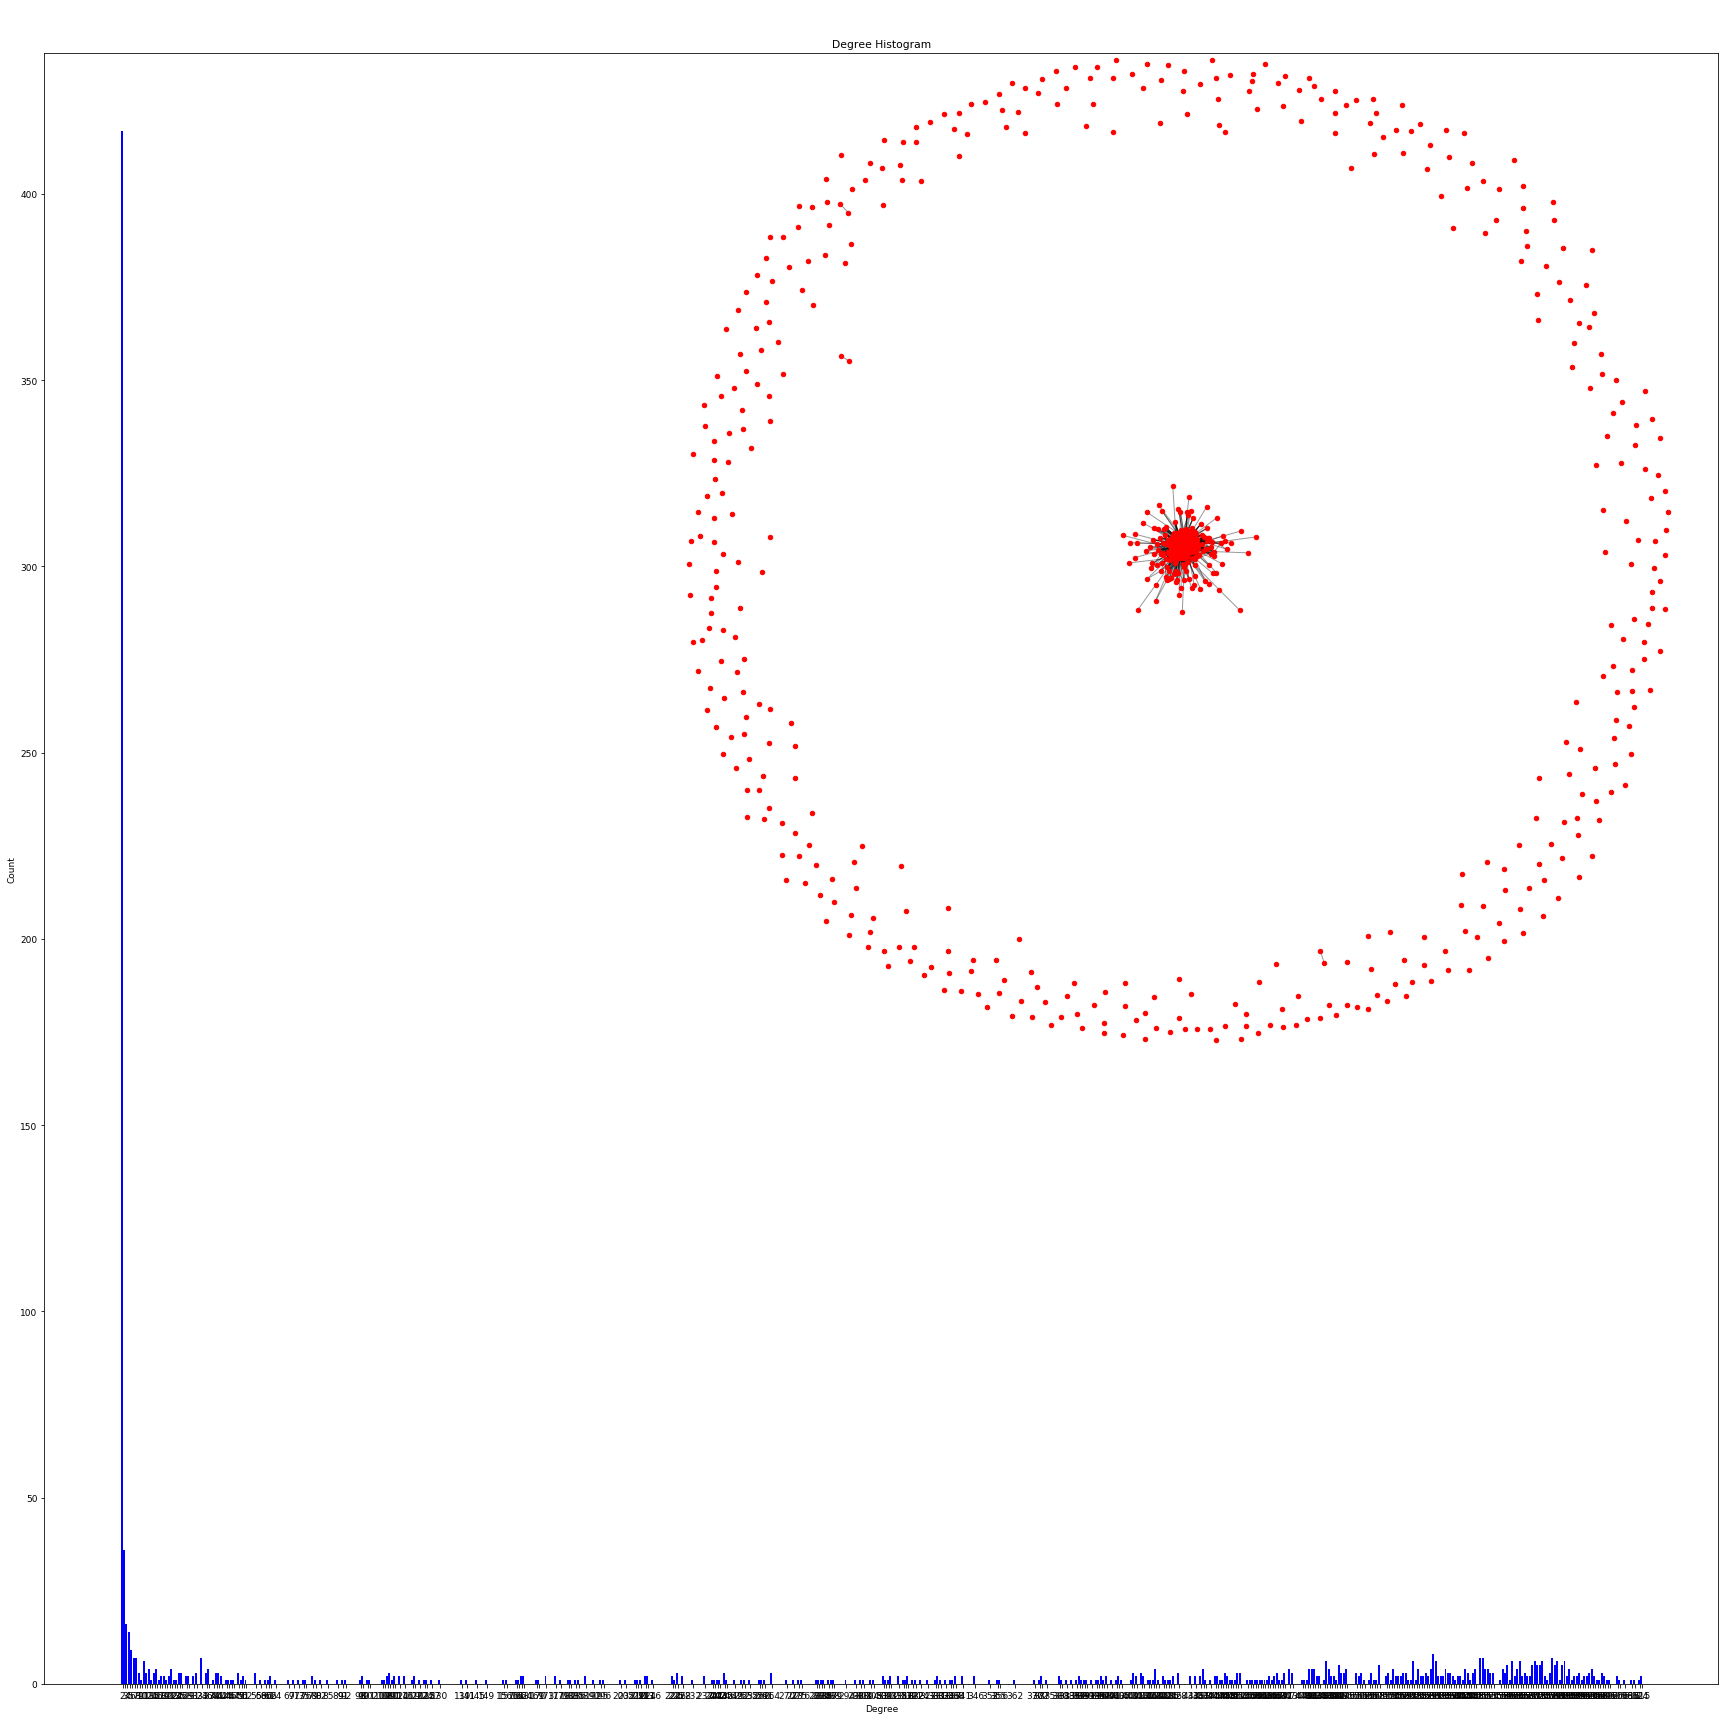

In [20]:
# PLOT DEGREE DISTRIBUTION OD TF_IDF AND DOC2VEC SIMILARITY GRAPHS WITH VARYING THRESHOLD VALUES
for i, adjacency_matrix in enumerate([tfidf_adjacency_matrix, doc2vec_adjacency_matrix]):
    if i == 0:
        printmd("** METHOD: TF-IDF ** \n")
        thresholds = [0.1, 0.2, 0.3, 0.4]
    else:
        printmd("** METHOD: DOC2VEC ** \n")
        thresholds = [0.5, 0.6, 0.7, 0.8]
    for threshold in thresholds:
        printmd("** Threshold: ** {}".format(threshold))
        graph = create_graph(adjacency_matrix, threshold=threshold)
        degree_sequence = sorted([d for n, d in graph.degree()], reverse=True)  # degree sequence
        # print "Degree sequence", degree_sequence
        degreeCount = collections.Counter(degree_sequence)
        deg, cnt = zip(*degreeCount.items())

        fig, ax = plt.subplots(figsize=(30, 30))
        plt.bar(deg, cnt, width=0.80, color='b')

        plt.title("Degree Histogram")
        plt.ylabel("Count")
        plt.xlabel("Degree")
        ax.set_xticks([d + 0.4 for d in deg])
        ax.set_xticklabels(deg)

        # draw graph in inset
        plt.axes([0.4, 0.4, 0.5, 0.5])
        Gcc = sorted(nx.connected_component_subgraphs(graph), key=len, reverse=True)[0]
        pos = nx.spring_layout(graph)
        plt.axis('off')
        nx.draw_networkx_nodes(graph, pos, node_size=20)
        nx.draw_networkx_edges(graph, pos, alpha=0.4)
        printmd("** Average degree count ** {}".format(np.mean(degree_sequence)))
        printmd("** Number of nodes without connection ** {}".format(len([x for x in degree_sequence if x <= 2])))
        plt.show()

In [21]:
# CREATE PERSONALIZATION DICT FOR PERONILIZED PAGE RANK
def create_personalization_dic(label, num_seed=1, level="first"):
    personlization = {}
    num_found = 0
    for i, (cur_labels1, cur_labels2) in enumerate(zip(first_level_labels, second_level_labels)):
        personlization[i] = 0
        if num_found < num_seed:
            for label1, label2 in zip(cur_labels1, cur_labels2):
                if level == "first":
                    label_ = label1
                elif level == "second":
                    label_ = label1 + "\n" + label2
                else:
                    raise IOError("level parameter must be 'first' or 'second'!")
                if label == label_:
                    personlization[i] = 1
                    num_found += 1
                    #print("Seed Sentence_{}={}\nLabel={}".format(num_found, sentences[i], label))
                    break
    return personlization

In [22]:
# CALCULATE RANDOM BASELINES USING STANDARD PAGE RANK ALGORITHM
results_dic = {}
precisions = []
recalls = []
fs = []
threshold_for_labeling = 0.001
label_set = second_level_labels_set
label_counts = second_level_label_counts
for l in label_set:
    ppr1 = nx.pagerank(tfidf_graph, max_iter=100)
    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
    corrects = sum([1 for prediction in predictions
                    if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                    and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                   ])

    relevant_count = label_counts[l]
    prediction_count = len(predictions)
    if prediction_count == 0:
        precision = 1
    else:
        precision = (corrects * 1.0) / prediction_count
    if relevant_count == 0:
        recall = 1
    else:
        recall = (corrects * 1.0) / relevant_count
    if precision == 0 and recall == 0:
        f = 0.0
    else:
        f = 2 * precision * recall / (precision + recall)
    precisions.append(precision)
    recalls.append(recall)
    fs.append(f)
average_precision = sum(precisions) / len(precisions)
average_recall = sum(recalls) / len(recalls)
average_f = sum(fs) / len(fs)
random_base_line_result = {"Average F1 Score": average_f,
                           "Average Precision": average_precision,
                           "Average Recall": average_recall,
                           "Labeling Threshold": threshold_for_labeling,
                           "Number of labeled reviews": "N/A"
                          }
results_dic["Random baseline"] = random_base_line_result
random_base_line_result_df = pd.DataFrame.from_dict(results_dic)
display(HTML(random_base_line_result_df.to_html()))

,Random baseline
Average F1 Score,0.114697
Average Precision,0.104678
Average Recall,0.192193
Labeling Threshold,0.001
Number of labeled reviews,N/A


In [23]:
# EVALUATE PERFORMANCE, EXPERIMENTS WITH VARYING THRESHOLDS and METHODS
thresholds_to_eval = [[0.001, 0.0015, 0.002, 0.0025, 0.0030, 0.0035], 
                      [0.001, 0.003, 0.005, 0.007, 0.009]]

num_seeds = [1, 5, 10, 20, 50]
for method, thresholds_for_labeling in zip(["DOC2VEC", "TF-IDF"], thresholds_to_eval):
    for i, num_seed in enumerate(num_seeds):
        for j, threshold_for_labeling in enumerate(thresholds_for_labeling):
            print("Calculating {} of {}...".format(i * len(thresholds_for_labeling) + j, len(num_seeds) * len(thresholds_for_labeling)))

            precisions = []
            recalls = []
            fs = []
            label_set = second_level_labels_set
            label_counts = second_level_label_counts
            for l in label_set:
                personalization = create_personalization_dic(l, num_seed=num_seed, level='second')
                if method == "TF-IDF":
                    ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
                else:
                    ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
                predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
                corrects = sum([1 for prediction in predictions
                                if re.sub("^.*\n", r"", l) in second_level_labels[prediction]
                                and re.sub("\n.*$", r"", l) in first_level_labels[prediction]
                               ])

                relevant_count = label_counts[l]
                prediction_count = len(predictions)
                if prediction_count == 0:
                    precision = 1
                else:
                    precision = (corrects * 1.0) / prediction_count
                if relevant_count == 0:
                    recall = 1
                else:
                    recall = (corrects * 1.0) / relevant_count
                if precision == 0 and recall == 0:
                    f = 0.0
                else:
                    f = 2 * precision * recall / (precision + recall)
                precisions.append(precision)
                recalls.append(recall)
                fs.append(f)
            average_precision = sum(precisions) / len(precisions)
            average_recall = sum(recalls) / len(recalls)
            average_f = sum(fs) / len(fs)
            result = {"Average F1 Score": average_f,
                      "Average Precision": average_precision,
                      "Average Recall": average_recall,
                      "Labeling Threshold": threshold_for_labeling,
                      "Number of labeled reviews": num_seed
                     }
            results_dic["{}\n [Labeling Threshold={},\n Number of labeled reviews={}]"
                        .format(method, threshold_for_labeling, num_seed)] = result
    result_df = pd.DataFrame.from_dict(results_dic)
    result_df.to_excel("Results.xlsx")
    display(HTML(result_df.to_html()))

Calculating 0 of 30...
Calculating 1 of 30...
Calculating 2 of 30...
Calculating 3 of 30...
Calculating 4 of 30...
Calculating 5 of 30...
Calculating 6 of 30...
Calculating 7 of 30...
Calculating 8 of 30...
Calculating 9 of 30...
Calculating 10 of 30...
Calculating 11 of 30...
Calculating 12 of 30...
Calculating 13 of 30...
Calculating 14 of 30...
Calculating 15 of 30...
Calculating 16 of 30...
Calculating 17 of 30...
Calculating 18 of 30...
Calculating 19 of 30...
Calculating 20 of 30...
Calculating 21 of 30...
Calculating 22 of 30...
Calculating 23 of 30...
Calculating 24 of 30...
Calculating 25 of 30...
Calculating 26 of 30...
Calculating 27 of 30...
Calculating 28 of 30...
Calculating 29 of 30...


,"DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=5]",Random baseline
Average F1 Score,0.251739,0.129572,0.407878,0.557877,0.259096,0.343095,0.113172,0.460800,0.660111,0.279561,0.366362,0.100908,0.500071,0.703789,0.264124,0.363741,0.100908,0.500503,0.709205,0.252888,0.363795,0.100908,0.500012,0.712201,0.252257,0.363795,0.100908,0.502643,0.677886,0.251714,0.114697
Average Precision,0.408965,0.778895,0.542656,0.543759,0.474347,0.738714,0.782543,0.818458,0.859613,0.817635,0.911693,0.936404,0.923902,0.947626,0.817758,0.936111,0.936404,0.950465,0.975094,0.864583,0.945513,0.936404,0.953759,0.984499,0.883700,0.945513,0.936404,0.970191,0.987519,0.928571,0.104678
Average Recall,0.374883,0.156263,0.489042,0.717912,0.264825,0.307775,0.102709,0.420455,0.655805,0.218985,0.292199,0.065968,0.415314,0.651792,0.199526,0.290526,0.065968,0.414634,0.651603,0.192562,0.290526,0.065968,0.414322,0.651603,0.192198,0.290526,0.065968,0.414132,0.613584,0.191858,0.192193
Labeling Threshold,0.001000,0.001000,0.001000,0.001000,0.001000,0.001500,0.001500,0.001500,0.001500,0.001500,0.002000,0.002000,0.002000,0.002000,0.002000,0.002500,0.002500,0.002500,0.002500,0.002500,0.003000,0.003000,0.003000,0.003000,0.003000,0.003500,0.003500,0.003500,0.003500,0.003500,0.001
Number of labeled reviews,10.000000,1.000000,20.000000,50.000000,5.000000,10.000000,1.000000,20.000000,50.000000,5.000000,10.000000,1.000000,20.000000,50.000000,5.000000,10.000000,1.000000,20.000000,50.000000,5.000000,10.000000,1.000000,20.000000,50.000000,5.000000,10.000000,1.000000,20.000000,50.000000,5.000000,N/A


Calculating 0 of 25...
Calculating 1 of 25...
Calculating 2 of 25...
Calculating 3 of 25...
Calculating 4 of 25...
Calculating 5 of 25...
Calculating 6 of 25...
Calculating 7 of 25...
Calculating 8 of 25...
Calculating 9 of 25...
Calculating 10 of 25...
Calculating 11 of 25...
Calculating 12 of 25...
Calculating 13 of 25...
Calculating 14 of 25...
Calculating 15 of 25...
Calculating 16 of 25...
Calculating 17 of 25...
Calculating 18 of 25...
Calculating 19 of 25...
Calculating 20 of 25...
Calculating 21 of 25...
Calculating 22 of 25...
Calculating 23 of 25...
Calculating 24 of 25...


,"DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.001, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0015, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.002, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0025, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.003, Number of labeled reviews=5]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=10]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=1]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=20]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=50]","DOC2VEC [Labeling Threshold=0.0035, Number of labeled reviews=5]",Random baseline,"TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.001, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.003, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.005, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.007, Number of labeled reviews=5]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=10]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=1]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=20]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=50]","TF-IDF [Labeling Threshold=0.009, Number of labeled reviews=5]"
Average F1 Score,0.251739,0.129572,0.407878,0.557877,0.259096,0.343095,0.113172,0.460800,0.660111,0.279561,0.366362,0.100908,0.500071,0.703789,0.264124,0.363741,0.100908,0.500503,0.709205,0.252888,0.363795,0.100908,0.500012,0.712201,0.252257,0.363795,0.100908,0.502643,0.677886,0.251714,0.114697,0.209470,0.141799,0.238351,0.30103

In [27]:
# SELECT BEST CONFIGURATION
best_tfidf_threshold = 0.0
best_doc2vec_threshold = 0.0
max_acc = 0.0
best_conf = ""
for conf_name, conf_dic in results_dic.items():
    if conf_dic["Average F1 Score"] > max_acc:
        max_acc = conf_dic["Average F1 Score"]
        best_conf = conf_name
        if conf_name.startswith("TF-IDF"):
            best_tfidf_threshold = conf_dic["Labeling Threshold"]
        else:
            best_doc2vec_threshold = conf_dic["Labeling Threshold"]
printmd("** Best Configuration: ** {}".format(best_conf))
printmd("** Best F1 Score: ** {}".format(max_acc))
printmd("** Best threshold for doc2vec: ** {}".format(best_doc2vec_threshold))

** Best Configuration: ** DOC2VEC
 [Labeling Threshold=0.003,
 Number of labeled reviews=50]

** Best F1 Score: ** 0.712200616702579

** Best threshold for doc2vec: ** 0.003

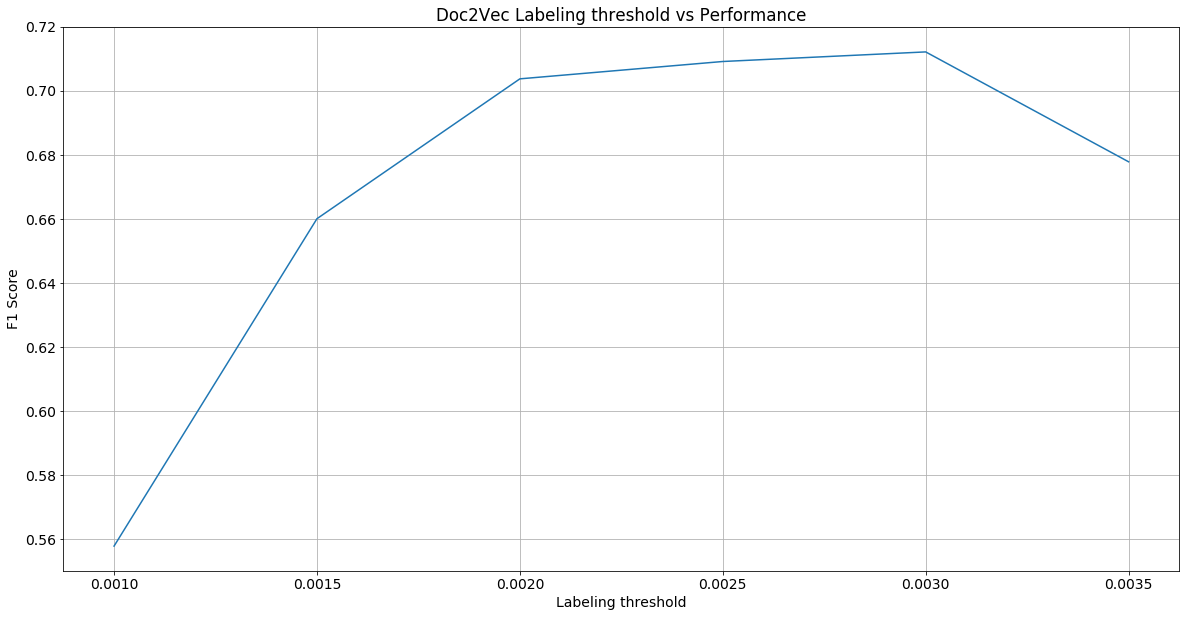

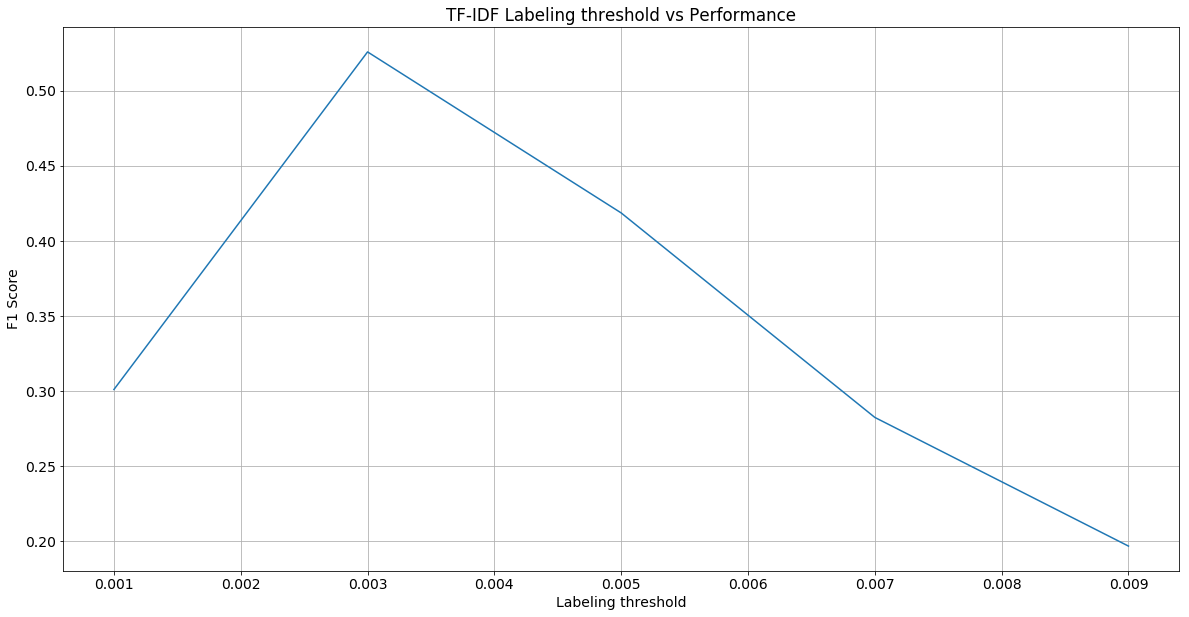

In [25]:
# Labeling Threshold - F Score plot 
doc2vec_threshold = []
doc2vec_f_scores = []
tf_idf_threshold = []
tf_idf_f_scores = []
for conf_name, conf_dic in results_dic.items():
    if conf_name.startswith("TF-IDF") and conf_dic["Number of labeled reviews"] == 50:
        if "first" not in conf_name:
            tf_idf_threshold.append(conf_dic["Labeling Threshold"])
            tf_idf_f_scores.append(conf_dic["Average F1 Score"])
    elif conf_dic["Number of labeled reviews"] == 50:
        if "first" not in conf_name:
            doc2vec_threshold.append(conf_dic["Labeling Threshold"])
            doc2vec_f_scores.append(conf_dic["Average F1 Score"])
tf_idf_threshold, tf_idf_f_scores = zip(*sorted(zip(tf_idf_threshold, tf_idf_f_scores)))
doc2vec_threshold, doc2vec_f_scores = zip(*sorted(zip(doc2vec_threshold, doc2vec_f_scores)))
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Doc2Vec Labeling threshold vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Labeling threshold")
plt.plot(doc2vec_threshold, doc2vec_f_scores)
# plt.plot(tf_idf_threshold, tf_idf_f_scores)
plt.grid(True)
plt.autoscale()
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("TF-IDF Labeling threshold vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Labeling threshold")
plt.plot(tf_idf_threshold, tf_idf_f_scores)
plt.grid(True)
plt.autoscale()

ValueError: not enough values to unpack (expected 2, got 0)

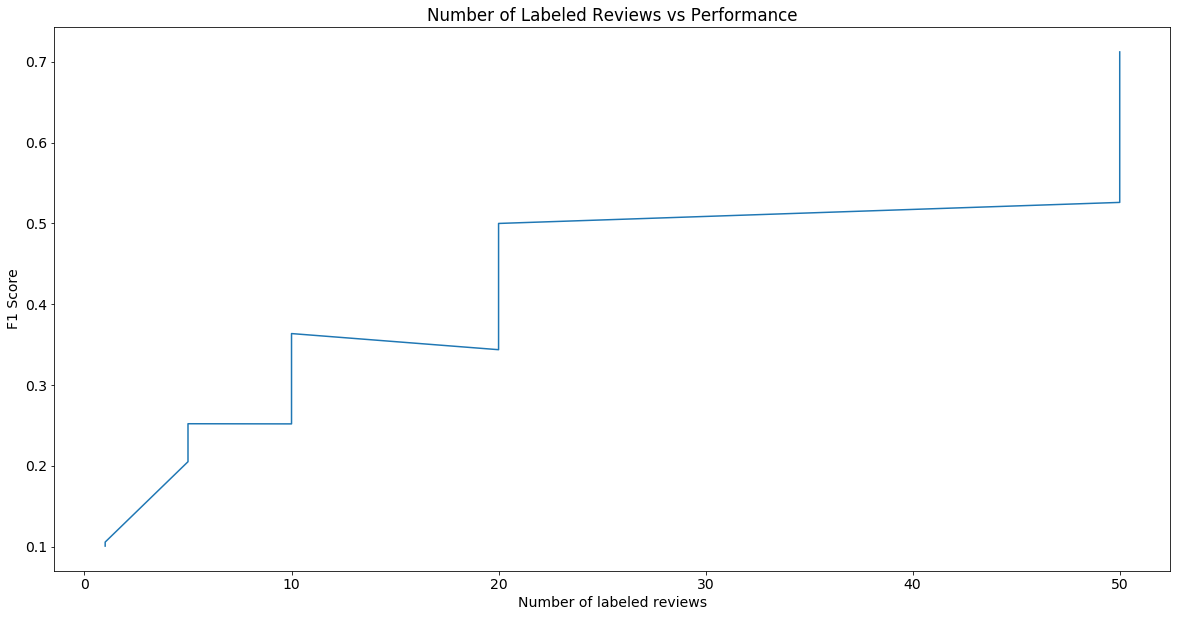

In [26]:
# Number of labeled reviews - F Score plot
doc2vec_num_seed = []
doc2vec_f_scores = []
tf_idf_num_seed = []
tf_idf_f_scores = []
for conf_name, conf_dic in results_dic.items():
    if conf_name.startswith("TF-IDF") and conf_dic["Labeling Threshold"] == best_tfidf_threshold:
        if "first" not in conf_name:
            tf_idf_num_seed.append(conf_dic["Number of labeled reviews"])
            tf_idf_f_scores.append(conf_dic["Average F1 Score"])
    elif conf_dic["Labeling Threshold"] == best_doc2vec_threshold:
        if "first" not in conf_name:
            doc2vec_num_seed.append(conf_dic["Number of labeled reviews"])
            doc2vec_f_scores.append(conf_dic["Average F1 Score"])
matplotlib.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(figsize=(20, 10))
plt.title("Number of Labeled Reviews vs Performance")
plt.ylabel("F1 Score")
plt.xlabel("Number of labeled reviews")
doc2vec_num_seed, doc2vec_f_scores = zip(*sorted(zip(doc2vec_num_seed, doc2vec_f_scores)))
plt.plot(doc2vec_num_seed, doc2vec_f_scores)
tf_idf_num_seed, tf_idf_f_scores = zip(*sorted(zip(tf_idf_num_seed, tf_idf_f_scores)))
plt.plot(tf_idf_num_seed, tf_idf_f_scores)
plt.plot(tf_idf_num_seed, 
         len(tf_idf_num_seed) * [random_base_line_result_df["Random baseline"]["Average F1 Score"]])
# plt.yscale('log')
plt.grid(True)
plt.legend(['Doc2Vec', 
            'TF-IDF', 
            'Random baseline'
           ], loc='upper left')

In [ ]:
# PREDICTIONS WITH BEST CONFIGURATION
num_seed = 50
method = "DOC2VEC"
threshold_for_labeling = best_doc2vec_threshold
doc2vec_f_scores = "second"

model_outputs = []
label_set = second_level_labels_set
for raw_text, cur_labels1, cur_labels2 in zip(raw_reviews, first_level_labels, second_level_labels):
    model_outputs.append({"Text": raw_text, 
                          "Predicted labels": "",
                          "Gold labels": " ".join(
                              [cur_label1 + "/" + cur_label2
                               for cur_label1, cur_label2 in zip(cur_labels1, cur_labels2)]
                          )
                         })

for l in label_set:
    personalization = create_personalization_dic(l, num_seed=num_seed, level='second')
    if method == "TF-IDF":
        ppr1 = nx.pagerank(tfidf_graph, personalization=personalization, max_iter=100)
    else:
        ppr1 = nx.pagerank(doc2vec_graph, personalization=personalization, max_iter=100)
    predictions = [k for k, v in ppr1.items() if v >= threshold_for_labeling]
    for prediction in predictions:
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"] + " " + l.replace("\n","/")
        model_outputs[prediction]["Predicted labels"] = model_outputs[prediction]["Predicted labels"].strip()

model_predictions_df = pd.DataFrame.from_dict(model_outputs)
model_predictions_df.to_excel("Model Predictions.xlsx")
display(HTML(model_predictions_df.to_html()))